### Data Preparation

Now that I have accesss to the individual game data, I need to prepare it for modeling. I will load all the necessary libraries, store each database table and CSV as a dataframe, then analyze the raw data in the modeling section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# set seed for reproducibility
seed=99

First, store each database table and CSV as a dataframe:

In [2]:
# database tables
game_info = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/game_info.csv', index_col=0)
team_stats = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_stats.csv', index_col=0)

# four factor data (10, 20, 30 game averages)
team_factor_10 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_10.csv', index_col=0)
team_factor_20 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_20.csv', index_col=0)
team_factor_30 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_30.csv', index_col=0)

# all boxscore data (10, 20, 30 game averages)
team_full_10 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_10.csv', index_col=0)
team_full_20 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_20.csv', index_col=0)
team_full_30 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_30.csv', index_col=0)

Before modeling, I will take a look at the first aggregated dataset to get a sense of the distribution:

In [3]:
team_factor_10

game_id  season        date away_team  away_score home_team  \
0      131410290001    1314  2013-10-29       ORL          87       IND   
1      131410290002    1314  2013-10-29       CHI          95       MIA   
2      131410290003    1314  2013-10-29       LAC         103       LAL   
3      131410300004    1314  2013-10-30       BRK          94       CLE   
4      131410300005    1314  2013-10-30       BOS          87       TOR   
...             ...     ...         ...       ...         ...       ...   
11974  222304091226    2223  2023-04-09       UTA         117       LAL   
11975  222304091227    2223  2023-04-09       NOP         108       MIN   
11976  222304091228    2223  2023-04-09       MEM         100       OKC   
11977  222304091229    2223  2023-04-09       LAC         119       PHO   
11978  222304091230    2223  2023-04-09       GSW         157       POR   

       home_score  result    a_eFGp     a_FTr  a_ORBp    a_TOVp    h_eFGp  \
0              97       1       NaN       NaN     NaN       NaN       NaN   
1             107       1       NaN       NaN     NaN       NaN       NaN   
2             116       1       NaN       NaN     NaN       NaN       NaN   
3              98       1       NaN       NaN     NaN       NaN       NaN   
4              93       1       NaN       NaN     NaN       NaN       NaN   
...           ...     ...       ...       ...     ...       ...       ...   
11974         128       1  0.526835  0.203724  0.2417  0.127276  0.571512   
11975         113       1  0.572581  0.215438  0.2313  0.121103  0.560502   
11976         115       1  0.593341  0.179039  0.2285  0.112724  0.506515   
11977         114       0  0.596108  0.208726  0.2185  0.126932  0.534066   
11978         101       0  0.570067  0.202915  0.3134  0.135201  0.516040   

          h_FTr  h_ORBp    h_TOVp  
0           NaN     NaN       NaN  
1           NaN     NaN       NaN  
2           NaN     NaN       NaN  
3           NaN     NaN       NaN  
4           NaN     NaN       NaN  
...         ...     ...       ...  
11974  0.262791  0.2569  0.118315  
11975  0.207763  0.2320  0.119090  
11976  0.235613  0.2587  0.092797  
11977  0.202198  0.2686  0.098874  
11978  0.170354  0.1848  0.111775  

[11979 rows x 16 columns]

In [4]:
team_factor_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11979 entries, 0 to 11978
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   game_id     11979 non-null  int64  
 1   season      11979 non-null  int64  
 2   date        11979 non-null  object 
 3   away_team   11979 non-null  object 
 4   away_score  11979 non-null  int64  
 5   home_team   11979 non-null  object 
 6   home_score  11979 non-null  int64  
 7   result      11979 non-null  int64  
 8   a_eFGp      11966 non-null  float64
 9   a_FTr       11966 non-null  float64
 10  a_ORBp      11966 non-null  float64
 11  a_TOVp      11966 non-null  float64
 12  h_eFGp      11961 non-null  float64
 13  h_FTr       11961 non-null  float64
 14  h_ORBp      11961 non-null  float64
 15  h_TOVp      11961 non-null  float64
dtypes: float64(8), int64(5), object(3)
memory usage: 1.6+ MB


The very first game for each team contains NaN values since there is no previous data, so they will need to be dropped.

In [5]:
team_factor_10.describe()

game_id        season    away_score    home_score        result  \
count  1.197900e+04  11979.000000  11979.000000  11979.000000  11979.000000   
mean   1.763236e+11   1763.175557    106.328325    108.643042      0.572502   
std    2.920031e+10    292.003775     13.135676     13.018141      0.494736   
min    1.314010e+11   1314.000000     66.000000     64.000000      0.000000   
25%    1.516032e+11   1516.000000     97.000000    100.000000      0.000000   
50%    1.718121e+11   1718.000000    106.000000    108.000000      1.000000   
75%    2.021032e+11   2021.000000    115.000000    117.000000      1.000000   
max    2.223123e+11   2223.000000    176.000000    175.000000      1.000000   

             a_eFGp         a_FTr        a_ORBp        a_TOVp        h_eFGp  \
count  11966.000000  11966.000000  11966.000000  11966.000000  11961.000000   
mean       0.519998      0.203046      0.233570      0.123494      0.519387   
std        0.031223      0.031784      0.033936      0.014691      0.031091   
min        0.415638      0.064516      0.108000      0.070244      0.388889   
25%        0.498224      0.180513      0.210200      0.113184      0.498214   
50%        0.520177      0.200895      0.232900      0.122899      0.519298   
75%        0.540838      0.222869      0.255800      0.133110      0.539752   
max        0.642857      0.358025      0.422000      0.224873      0.627059   

              h_FTr        h_ORBp        h_TOVp  
count  11961.000000  11961.000000  11961.000000  
mean       0.203006      0.233158      0.123541  
std        0.031842      0.033643      0.014436  
min        0.086022      0.116500      0.066163  
25%        0.180751      0.209900      0.113581  
50%        0.200935      0.232800      0.123143  
75%        0.223267      0.254600      0.132919  
max        0.368889      0.361000      0.218341

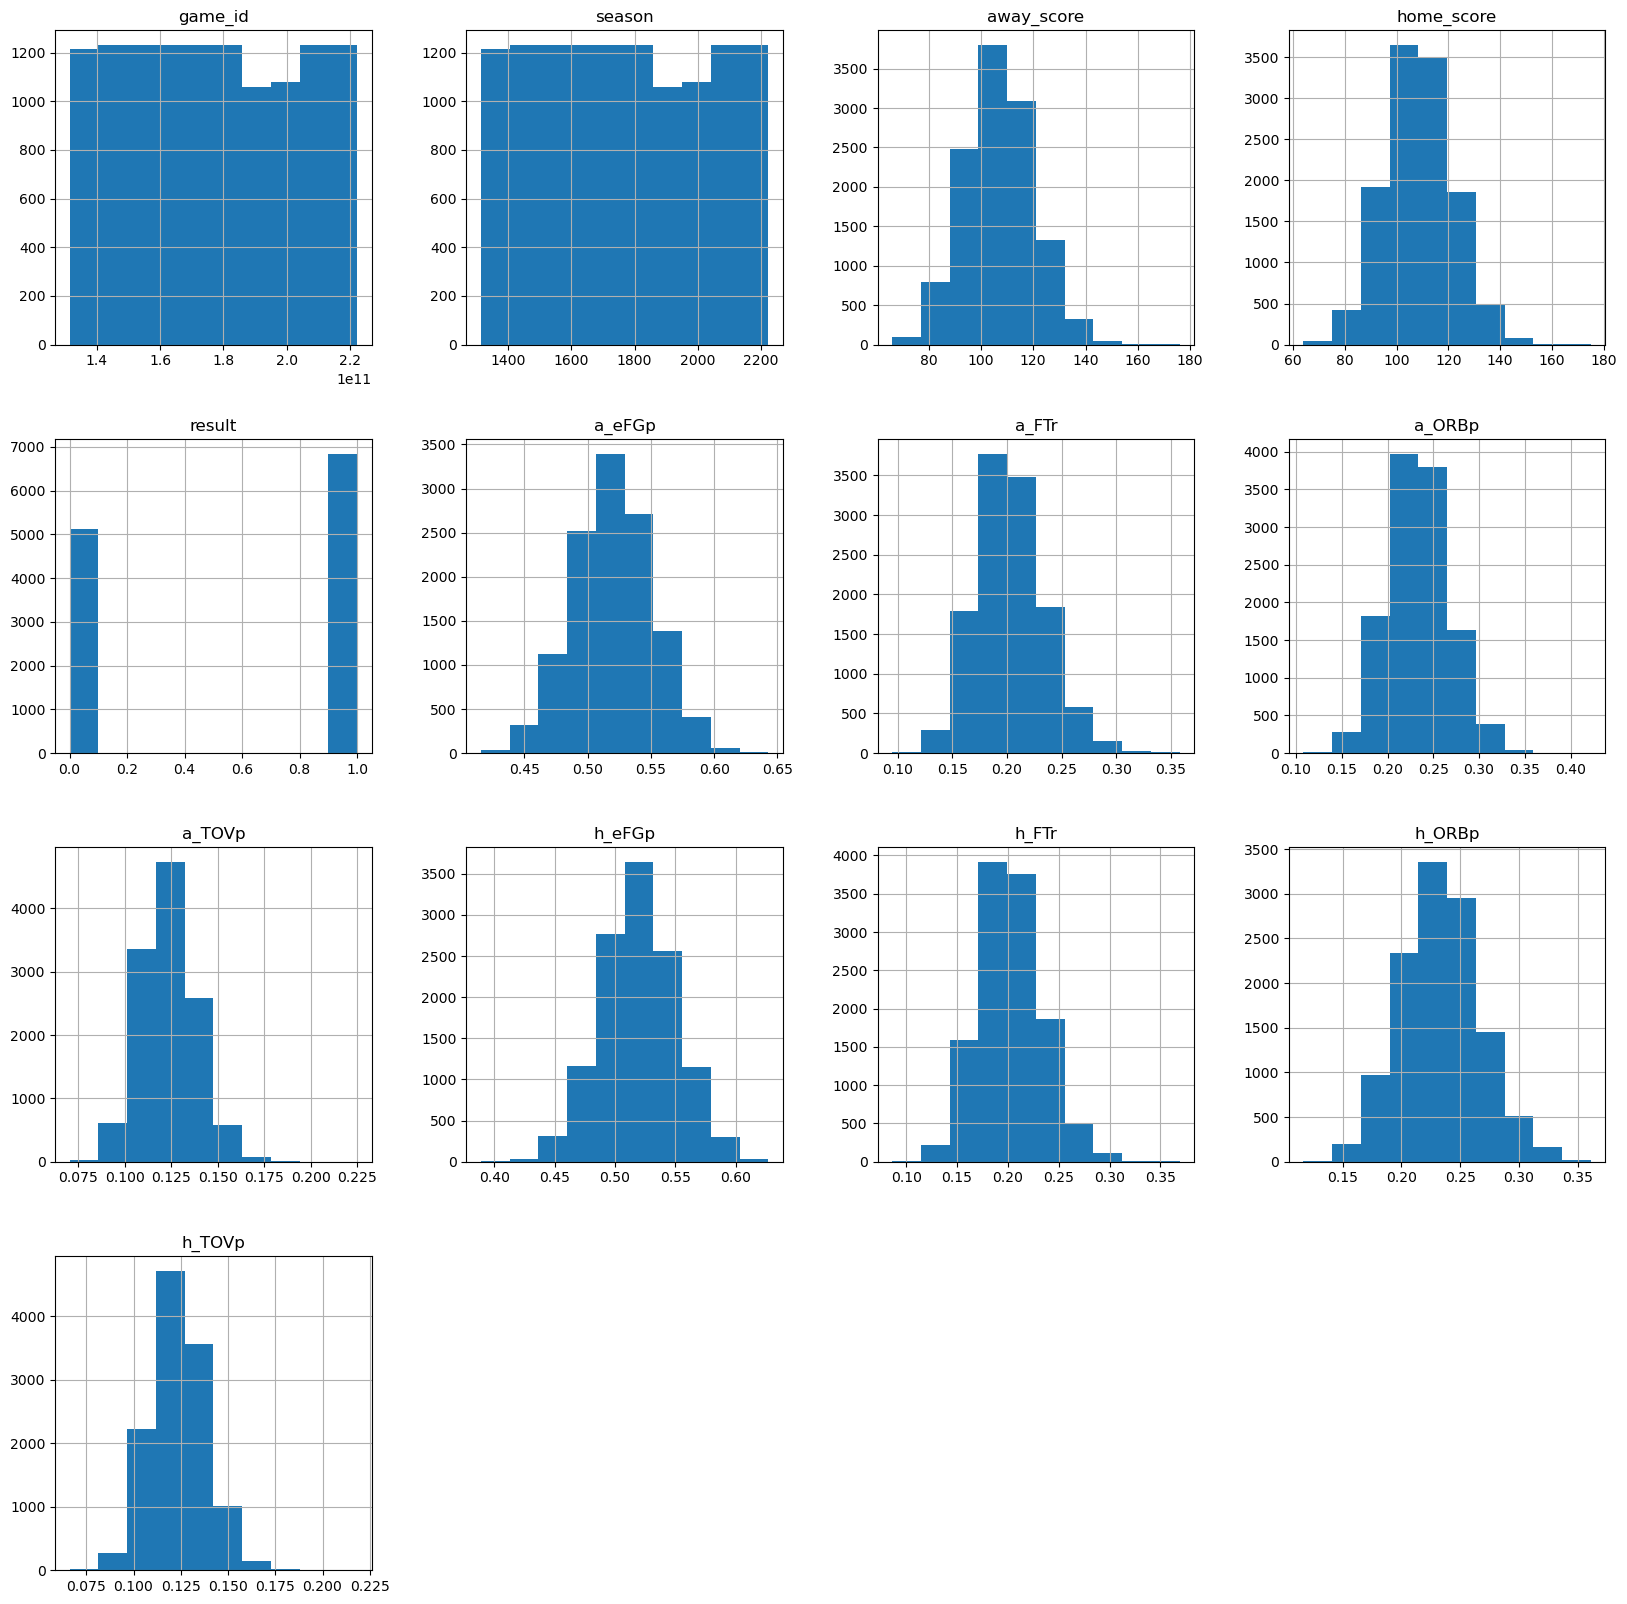

In [6]:
team_factor_10.dropna(inplace=True)
team_factor_10.reset_index(drop=True, inplace=True)
team_factor_10.hist(figsize=(20,20));

In [7]:
game_info['result'].value_counts(normalize=True)

1    0.572502
0    0.427498
Name: result, dtype: float64

### Model Target

Traditionally, the NBA has an upset rate of between 28-32%, meaning that the "better" team wins 68-72% of the time. Because of this, it is very challenging to create a model with an accuracy higher than 68-72%. Given the limitations of the data I am using, I hope to achieve an accuracy that approaches the 68% threshold.


Next, I need to create a class that will allow me to easily train and evaluate each model:

In [8]:
# create results and residuals df to hold modeling results
results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df = pd.DataFrame(columns=['y_true'])
residuals_df['y_true'] = team_factor_10['result']

In [9]:
class ModelEval():
    '''
    A pipeline to process data, perform cross validation and grid search,
    fit model, calculate model predictions and accuracy, create confidence matrix,
    and log results.
    
    Parameters
    ----------
    model : an instantiated scikit-learn model object.
    
    model_name : a string with the model name
    
    results_df : dataframe to hold the results for each successive model
    
    residuals_df : dataframe to hold the predictions for each successive model
    
    stats : X_train, X_test, y_train, y_test from sklearn.model_selection.train_test_split
    
    param_grid : the parameter grid used in the model grid search
    
    scaler : a 'yes'/'no' string indicating whether the model requires
             scaling the data with sklearn.preprocessing.StandardScaler
    
    pca : a 'yes'/'no' string indicating whether or not to perform scaling and PCA on the data.
    '''
    
    def __init__(self, model, model_name, results_df, residuals_df, stats, param_grid, scaler='no', pca='no', n_components=None):
        
        self.model = model
        self.model_name = model_name
        self.results_df = results_df
        self.residuals_df = residuals_df
        self.X_train, self.X_test, self.y_train, self.y_test = stats
        self.param_grid = param_grid
        self.cv_score = None
        self.gs_score = None
        
        if scaler == 'yes':
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            
        if pca == 'yes':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            self.X_train = X_train_pca
            self.X_test = X_test_pca

            self.explained_variance = sum(pca.explained_variance_ratio_)
    
    def calc_cv(self):
        
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=3)
        self.cv_score = cv_scores.mean()
        self.fitted_model = self.model.fit(self.X_train, self.y_train)
    
    def calc_grid_search(self):
        
        grid_search = GridSearchCV(self.model, self.param_grid, cv=3)
        self.fitted_model = grid_search.fit(self.X_train, self.y_train)
        self.params_model = grid_search.best_estimator_
        self.gs_score = grid_search.best_score_
        
    def calc_train_preds(self):
        
        self.train_preds = self.fitted_model.predict(self.X_train)
    
    def calc_test_preds(self):
        
        self.test_preds = self.fitted_model.predict(self.X_test)
    
    def calc_train_score(self):
        
        self.train_score = self.fitted_model.score(self.X_train, self.y_train)
    
    def calc_test_score(self):
    
        self.test_score = self.fitted_model.score(self.X_test, self.y_test)
    
    def create_conf_matrix(self):
        conf_matrix = confusion_matrix(y_true=self.y_test, y_pred=self.test_preds)
        self.disp = ConfusionMatrixDisplay(conf_matrix)
        return self.disp.plot();
    
    def record_results(self):
        
        idx = self.results_df.shape[0]
        results_df.loc[idx] = [self.model_name, self.cv_score, self.gs_score, self.train_score, self.test_score]
    
    def calc_residuals(self):
        
        train_preds_df = pd.DataFrame(self.train_preds, index=self.y_train.index)
        test_preds_df = pd.DataFrame(self.test_preds, index=self.y_test.index)
        
        self.model_preds = pd.concat([train_preds_df, test_preds_df]).sort_index()
        
        self.residuals_df[f'{self.model_name}' + '_residuals'] = self.residuals_df['y_true'] - self.model_preds[0]
    
    def full_diag(self):
        
        if self.param_grid == None:   
            self.calc_cv()
        else:
            self.calc_grid_search()
            
        self.calc_train_preds()
        self.calc_test_preds()
        self.calc_train_score()
        self.calc_test_score()
        self.create_conf_matrix()
        self.record_results()
        self.calc_residuals()

In [10]:
stat_columns = ['a_eFGp', 'a_FTr', 'a_ORBp', 'a_TOVp', 'h_eFGp', 'h_FTr', 'h_ORBp', 'h_TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

model_name  cv_score gs_score  train_score  test_score
0  log_4F_8var_10   0.60023     None     0.607441    0.598412

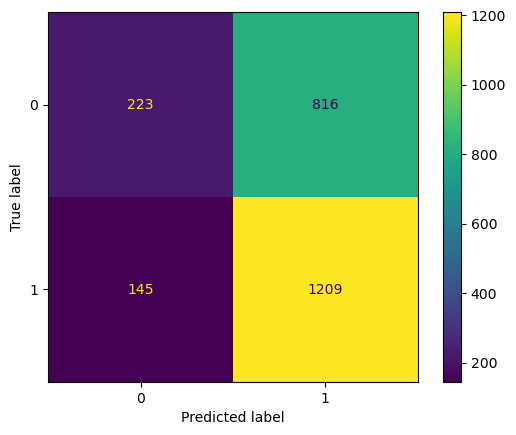

In [11]:
# instantiate model object
log = LogisticRegression(random_state=seed)

# train and evaluate the model
log_model = ModelEval(log, 'log_4F_8var_10', results_df, residuals_df, stats, None)
log_model.full_diag()

results_df

The model has an accuracy (`test_score`) of 59.8%. This is very close to the `cv_score` of 60%, so the model is likely not overfit. The confusion matrix shows that the model tends to predict home team victories at a very high rate (Predicted label 1). This leads to a lot of false positives, and is something that will need to be considered as we compare future models.

#### Logistic Regression (4 variables)

This time I will combine the away and home stats. In the case of `eFGp`, `FTr`, and `ORBp`, a positive total indicates that the away team has outperformed the home team in recent games, and opposite if the total is negative. But since teams want a low `TOVp`, a positive total indicates that the home team is outperforming the away team.

In [12]:
# combine away and home stats
team_factor_10['eFGp'] = team_factor_10['a_eFGp'] - team_factor_10['h_eFGp']
team_factor_10['FTr'] = team_factor_10['a_FTr'] - team_factor_10['h_FTr']
team_factor_10['ORBp'] = team_factor_10['a_ORBp'] - team_factor_10['h_ORBp']
team_factor_10['TOVp'] = team_factor_10['a_TOVp'] - team_factor_10['h_TOVp']

stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

model_name  cv_score gs_score  train_score  test_score
0  log_4F_8var_10  0.600230     None     0.607441    0.598412
1       log_4F_10  0.610995     None     0.615907    0.607188

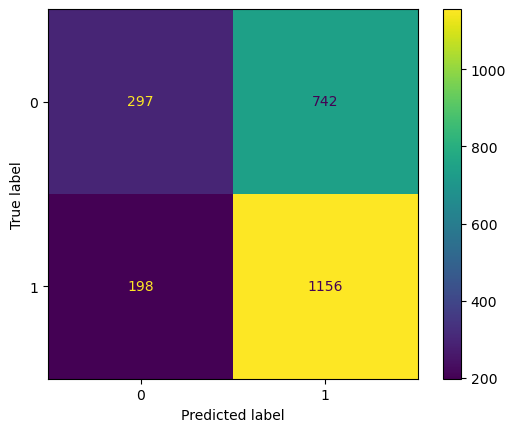

In [13]:
logreg = LogisticRegression(random_state=seed)
logreg_model = ModelEval(logreg, 'log_4F_10', results_df, residuals_df, stats, None)
logreg_model.full_diag()

results_df

It seems that combining the stats did lead to a slight increase in accuracy of about 1%. It is possible that this won't be the case for other models, but for now I will use the 4-variable model until I have narrowed the model selection process.

#### Logistic Regression Grid Search

This time I will perform a grid search with the logistic regression model. Included in the grid search are different penalties, which means that the model will be performing regularization. Because of this, I also need to scale the data. I have chosen `solver='saga'` because it is the only one that can be used with each `penalty` method. `C` determines the strength of the regularization penalty. A smaller `C` means the model will perform stronger regularization.

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306

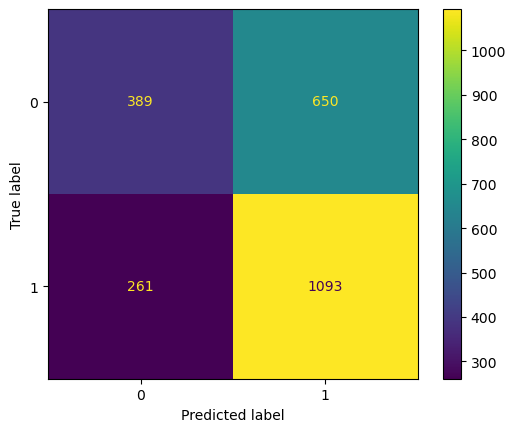

In [14]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_10', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

results_df

In [15]:
log_gs_model.params_model

LogisticRegression(C=0.1, random_state=99, solver='saga')

The grid search has improved accuracy, but the confusion matrices show that there are still a lot of false positives (650). A home-team win is represented as a 1, so this means the model tends to favor the home team. As noted earlier, since there is a definite home-court advantage, it is understandable that the model would err toward always choosing the home team. Now let's see how the other models perform.

#### K-Nearest Neighbors (KNN)

This model is a non-parametric, supervised learning classifier which will make a prediction based on the "nearest neighbor" datapoints. The assumption is that the other most-similar datapoints will likely have the same outcome as the datapoint in question. After some trial and error, I determined that the best performing models had a relatively high number of `n_neighbors`, which is reflected in the parameter grid.

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084

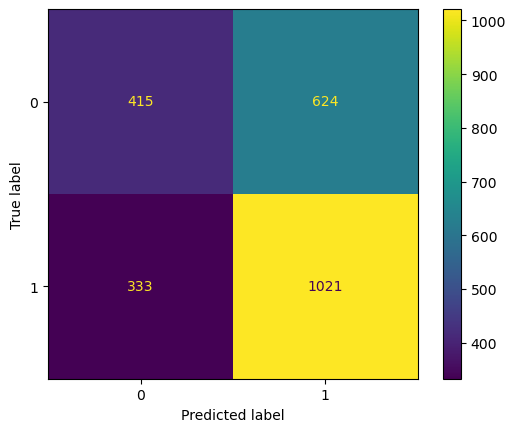

In [16]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_10', results_df, residuals_df, stats, knn_param_grid, scaler='yes')
knn_model.full_diag()

results_df

In [17]:
knn_model.params_model

KNeighborsClassifier(n_neighbors=21, p=1)

The KNN model is performing similarly to the logistic regression model. The train score is inflated since the model was fit on portions of the training data, but the increase in accuracy between the grid score and the test score indicate the model is likely not overfit.

#### Random Forest (RF)

The RF model is technically an ensemble method since it uses multiple decision trees to arrive at its predictions. Again, I have narrowed down the best possible grid parameters based on some trial and error.

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531

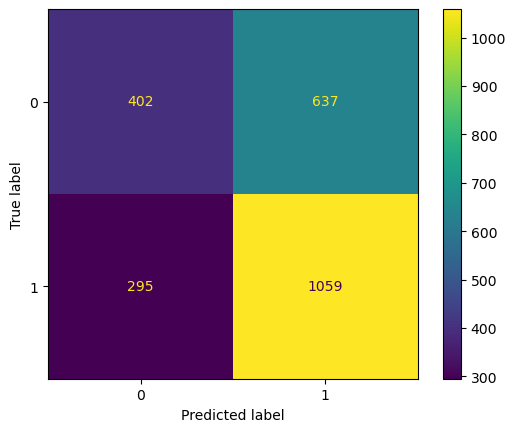

In [18]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [130, 140, 150],
    'max_depth': [5, 6],
    'min_samples_split': [2],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_10', results_df, residuals_df, stats, rfc_param_grid)
rfc_model.full_diag()

results_df

In [19]:
rfc_model.params_model

RandomForestClassifier(max_depth=5, max_features=None, n_estimators=140,
                       random_state=99)

The RF model is performing well, but is significantly more computationally expensive than the other models so far, meaning that it may not be the best choice.

#### Gaussian Naive Bayes (GNB)

The Gaussian Naive Bayes model assumes a gaussian, or normal, distribution of the data. Since the data is very normal, this model is an excellent candidate for the task at hand. It is also relatively quick and efficient, as compared to something like the RF model. It dos not have hyperparameters, so there is no need for a grid search.

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531
5       gnb_4F_10  0.613921      None     0.617057    0.610949

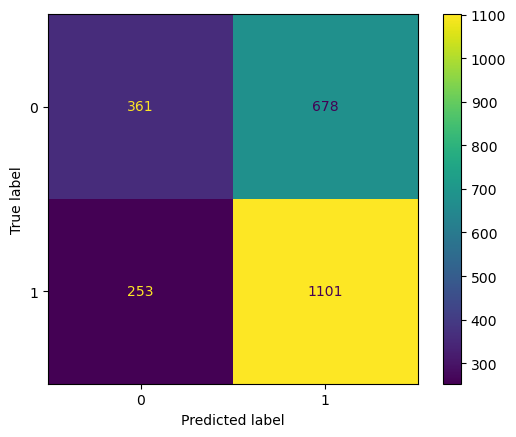

In [20]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_10', results_df, residuals_df, stats, None)
gnb_model.full_diag()

results_df

#### Support Vector Classifier (SVC)

SVCs make predictions by mapping the datapoints onto a multidimensional space and finding the optimal hyperplane for splitting the data into two classes, which in this case is away-team win and home-team win. Like the logistic regression model, it also has a regularization strength hyperparameter (`C`).

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531
5       gnb_4F_10  0.613921      None     0.617057    0.610949
6       svc_4F_10       NaN  0.618207     0.626359    0.608023

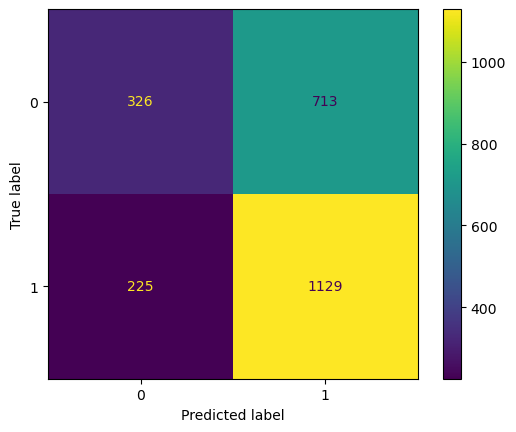

In [21]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_10', results_df, residuals_df, stats, svc_param_grid, scaler='yes')
svc_model.full_diag()

results_df

In [22]:
svc_model.params_model

SVC(C=1, gamma='auto', random_state=99)

In [23]:
residuals_df

y_true  log_4F_8var_10_residuals  log_4F_10_residuals  \
0           1                         1                    0   
1           1                         1                    1   
2           1                         1                    1   
3           1                         0                    0   
4           0                         0                    0   
...       ...                       ...                  ...   
11956       1                         0                    0   
11957       1                         0                    0   
11958       1                         1                    1   
11959       0                         0                    0   
11960       0                         0                    0   

       log_gs_4F_10_residuals  knn_4F_10_residuals  rfc_4F_10_residuals  \
0                           0                    1                    1   
1                           1                    1                    1   
2                           1                    1                    1   
3                           0                    0                    0   
4                           0                   -1                    0   
...                       ...                  ...                  ...   
11956                       0                    0                    0   
11957                       0                    1                    0   
11958                       1                    0                    1   
11959                       0                   -1                    0   
11960                       0                   -1                    0   

       gnb_4F_10_residuals  svc_4F_10_residuals  
0                        0                    0  
1                        1                    1  
2                        1                    1  
3                        0                    0  
4                        0                    0  
...                    ...                  ...  
11956                    0                    0  
11957                    0                    0  
11958                    1                    1  
11959                    0                   -1  
11960                    0                    0  

[11961 rows x 8 columns]

In [24]:
# create df with model errors and the season
error_df = residuals_df.drop(['y_true', 'log_4F_8var_10_residuals', 'log_4F_10_residuals'], axis=1)
error_df['season'] = team_factor_10['season']

# dictionary to store error counts for each model
error_dict = {}


for model in error_df.columns[:-1]:    # ignore the 'season' column
    
    # dictionary to store error counts for each season
    model_error = {}    
    for season in error_df['season'].unique():
        # pull predictions for specific model and season
        season_stats = error_df[model][error_df['season'] == season].to_frame()
        # split season into 4 quarters
        season_stats['bin'] = pd.cut(season_stats.index, bins=4, labels=[0,1,2,3])
        
        season_error_list = []
        for b in season_stats['bin'].unique():
            # store error counts for each quarter
            error_count = season_stats[model][season_stats['bin'] == b].astype(bool).sum(axis=0)
            season_error_list.append(error_count)
    
        model_error[season] = season_error_list
        
    error_dict[model] = model_error

# get average quarterly error across all seasons
for model in error_dict:
    
    q_avg = []
    for n in list(range(4)):

        avg_error = round(np.mean([season[n] for season in error_dict[model].values()]), 1)
        q_avg.append(avg_error)
    
    error_dict[model]['quarterly_error_avg'] = q_avg

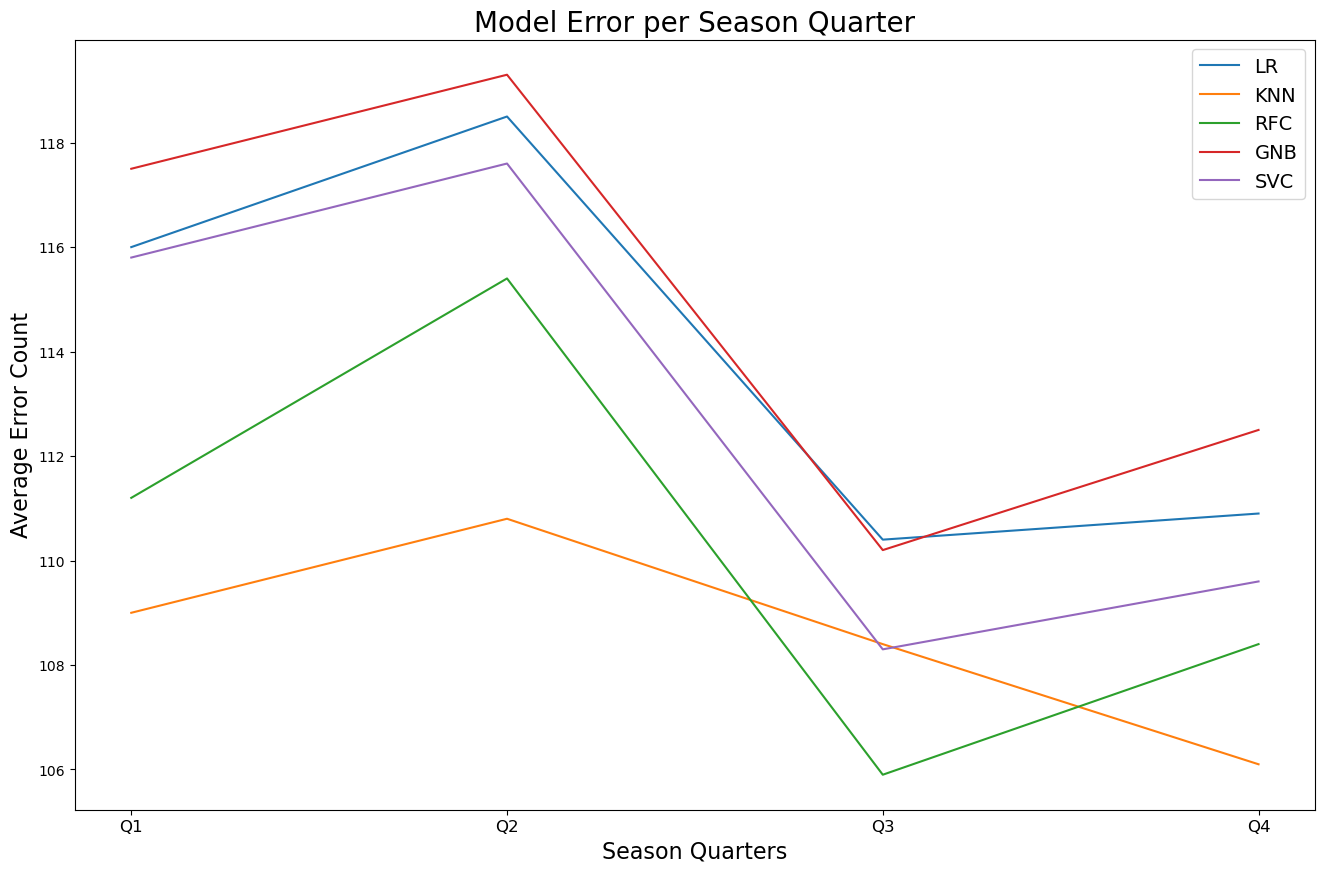

In [25]:
# model lables for the legend
labels = ['LR', 'KNN', 'RFC', 'GNB', 'SVC']

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Model Error per Season Quarter', fontsize=20)
ax.set_xlabel('Season Quarters', fontsize=16)
ax.set_ylabel('Average Error Count', fontsize=16)
ax.set_xticks(range(5))
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', ''], fontsize=12)

# plot average error per season quarter
key_list = list(error_dict.keys())
for idx in range(len(error_dict.keys())):
    plt.plot(error_dict[key_list[idx]]['quarterly_error_avg'], label=labels[idx])

plt.legend(fontsize=14);

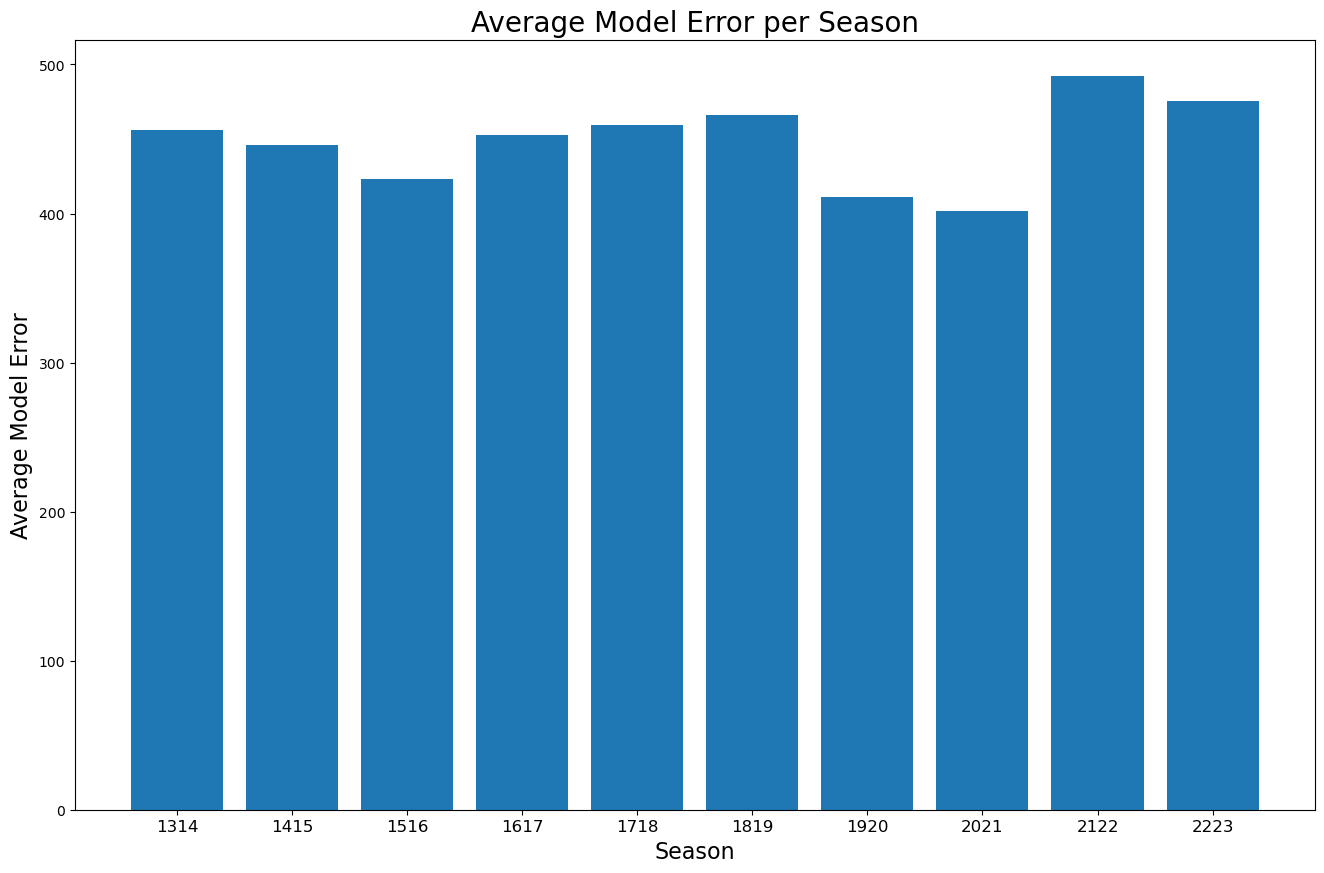

In [26]:
# dictionary to store per season error counts
season_avg_error = {}
for season in error_df['season'].unique():
    
    season_avg_error[season] = []
    for model in error_df.columns[:-1]:
        # sum of errors per season
        season_avg_error[season].append(sum(error_dict[model][season]))

for season in season_avg_error:
    # combine error sums from each model
    season_avg_error[season] = sum(season_avg_error[season])/len(error_df.columns[:-1])


fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Average Model Error per Season', fontsize=20)
ax.set_xlabel('Season', fontsize=16)
ax.set_ylabel('Average Model Error', fontsize=16)
ax.set_xticks(range(10))
ax.set_xticklabels([season for season in error_df['season'].unique()], fontsize=12)

# plot avergae error count per season
plt.bar(x=range(len(season_avg_error.keys())), height=season_avg_error.values());

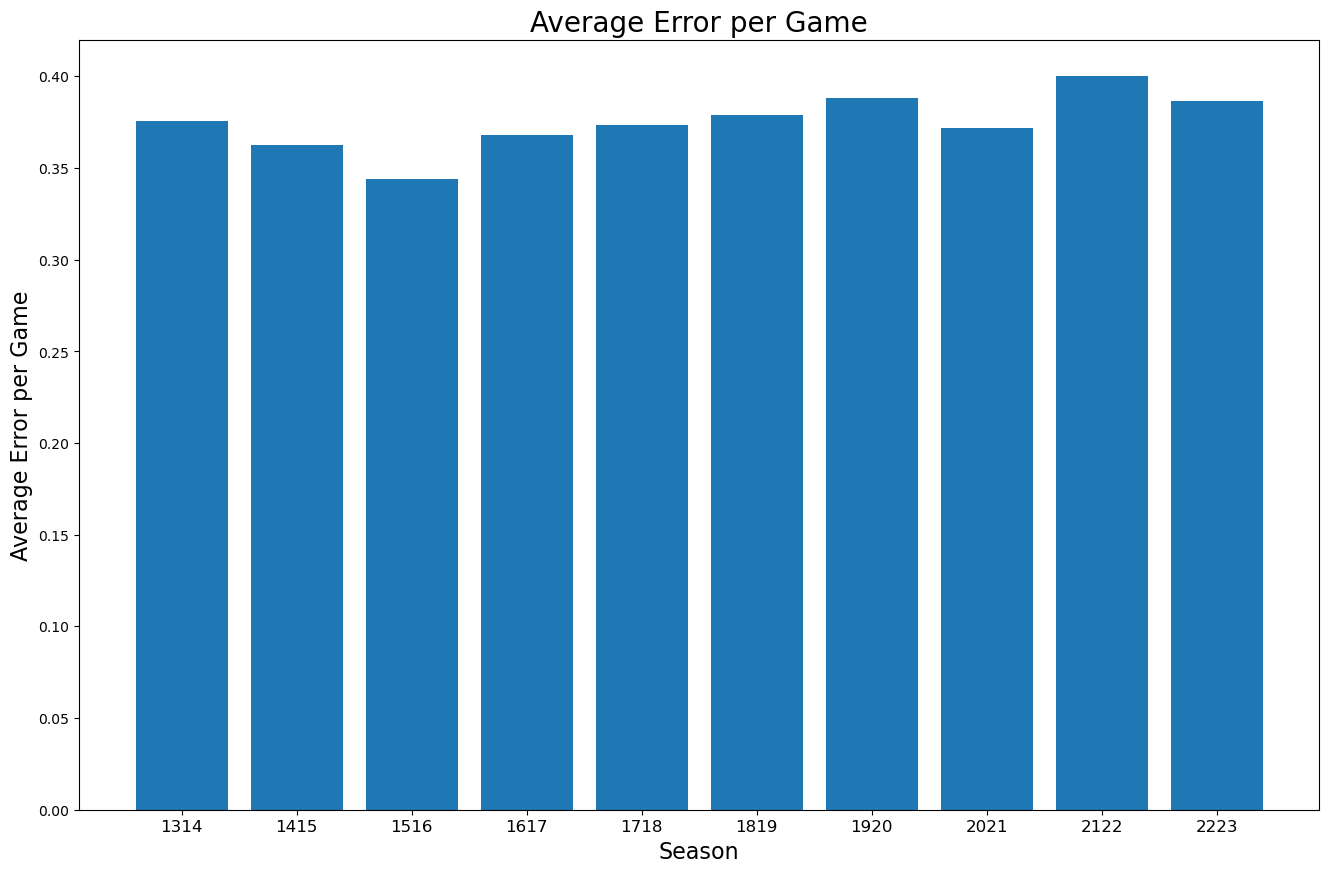

In [27]:
error_per_game = []
for season in season_avg_error:
    # divide overall average error by the number of games each season
    per_game_error = season_avg_error[season]/len(error_df[error_df['season'] == season])
    error_per_game.append(per_game_error)

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Average Error per Game', fontsize=20)
ax.set_xlabel('Season', fontsize=16)
ax.set_ylabel('Average Error per Game', fontsize=16)
ax.set_xticks(range(10))
ax.set_xticklabels([season for season in error_df['season'].unique()], fontsize=12)

# plot error per game by season
plt.bar(x=range(len(season_avg_error.keys())), height=error_per_game);

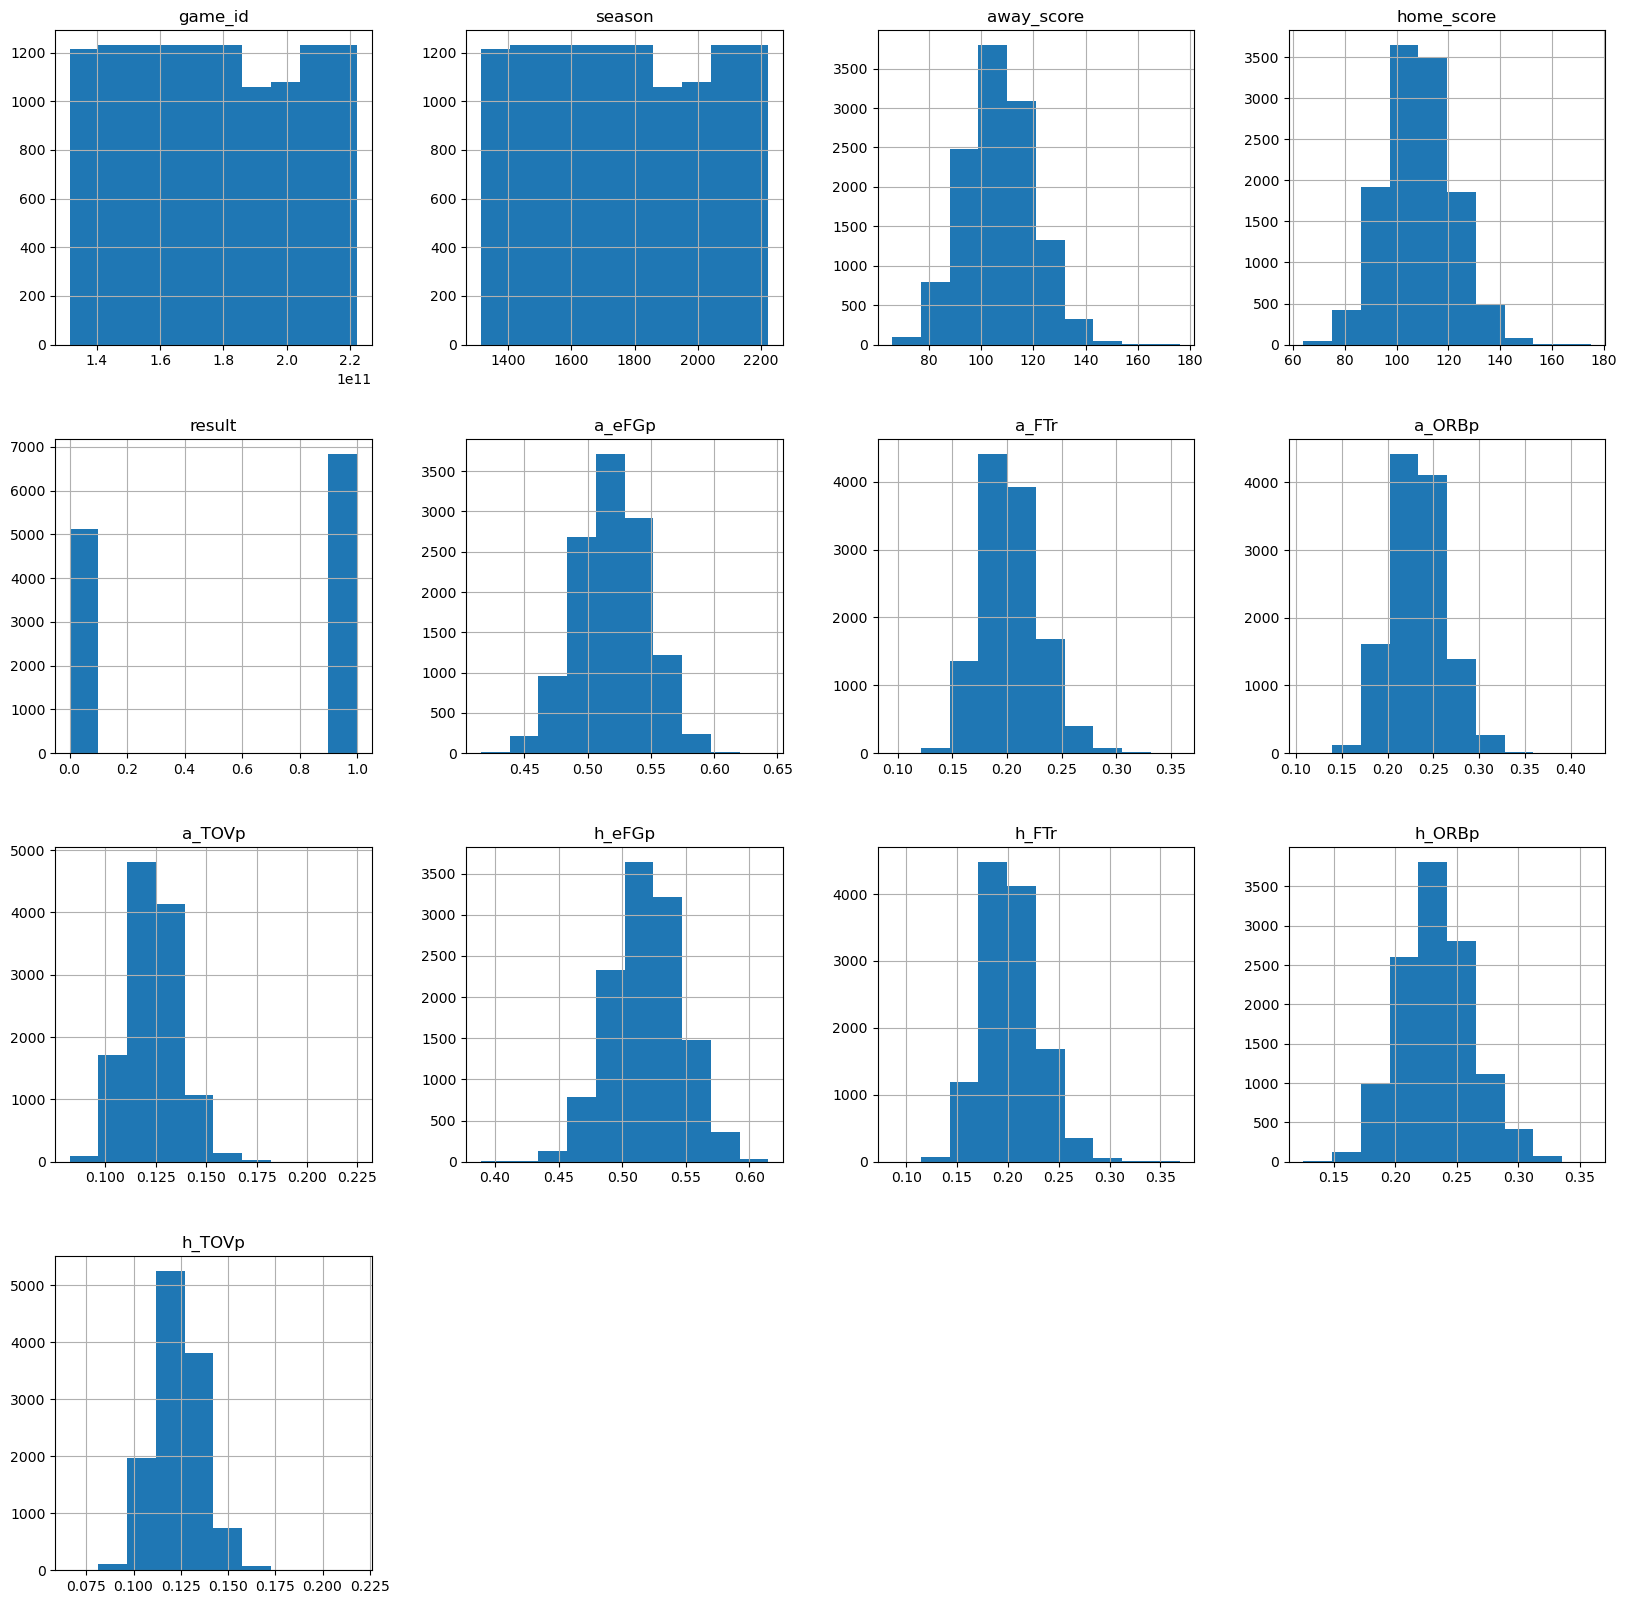

In [28]:
team_factor_20.dropna(inplace=True)
team_factor_20.reset_index(drop=True, inplace=True)
team_factor_20.hist(figsize=(20,20));

In [29]:
team_factor_20['eFGp'] = team_factor_20['a_eFGp'] - team_factor_20['h_eFGp']
team_factor_20['FTr'] = team_factor_20['a_FTr'] - team_factor_20['h_FTr']
team_factor_20['ORBp'] = team_factor_20['a_ORBp'] - team_factor_20['h_ORBp']
team_factor_20['TOVp'] = team_factor_20['a_TOVp'] - team_factor_20['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_20 = pd.DataFrame(columns=['y_true'])
residuals_df_20['y_true'] = game_info['result']

In [30]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_20[stat_columns]
y = team_factor_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531
5       gnb_4F_10  0.613921      None     0.617057    0.610949
6       svc_4F_10       NaN  0.618207     0.626359    0.608023
7    log_gs_4F_20       NaN  0.629911     0.629494    0.620560

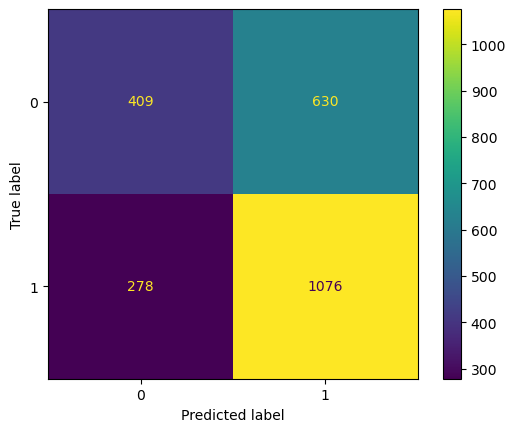

In [31]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_20', results_df, residuals_df_20, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

results_df

In [32]:
log_gs_model.params_model

LogisticRegression(C=0.01, penalty=None, random_state=99, solver='saga')

#### KNN

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531
5       gnb_4F_10  0.613921      None     0.617057    0.610949
6       svc_4F_10       NaN  0.618207     0.626359    0.608023
7    log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8       knn_4F_20       NaN  0.605141     0.650293    0.591308

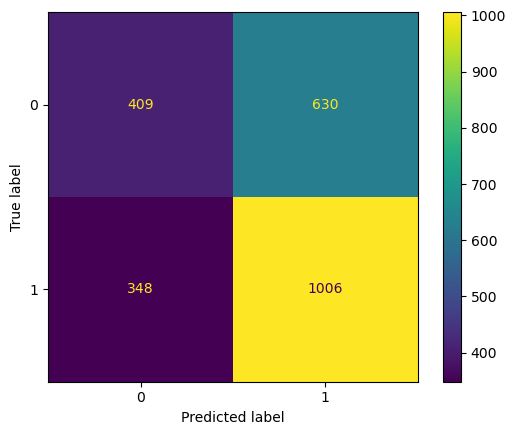

In [33]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [19, 21, 23],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_20', results_df, residuals_df_20, stats, knn_param_grid, scaler='yes')
knn_model.full_diag()

results_df

In [34]:
knn_model.params_model

KNeighborsClassifier(n_neighbors=23, p=3)

#### RF

model_name  cv_score  gs_score  train_score  test_score
0  log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1       log_4F_10  0.610995       NaN     0.615907    0.607188
2    log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3       knn_4F_10       NaN  0.590613     0.646112    0.600084
4       rfc_4F_10       NaN  0.620297     0.636601    0.610531
5       gnb_4F_10  0.613921      None     0.617057    0.610949
6       svc_4F_10       NaN  0.618207     0.626359    0.608023
7    log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8       knn_4F_20       NaN  0.605141     0.650293    0.591308
9       rfc_4F_20       NaN  0.630538     0.657086    0.617217

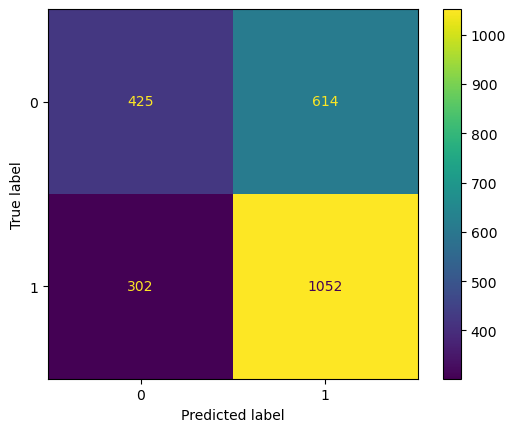

In [35]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [225, 250],
    'max_depth': [5, 6],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_20', results_df, residuals_df_20, stats, rfc_param_grid)
rfc_model.full_diag()

results_df

In [36]:
rfc_model.params_model

RandomForestClassifier(max_depth=6, min_samples_leaf=4, n_estimators=250,
                       random_state=99)

#### GNB

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874

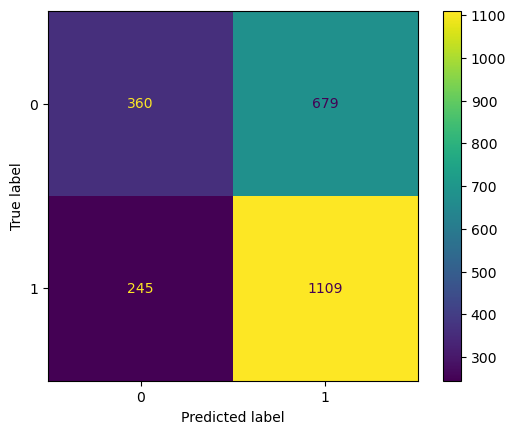

In [37]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_20', results_df, residuals_df_20, stats, None)
gnb_model.full_diag()

results_df

#### SVC

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560

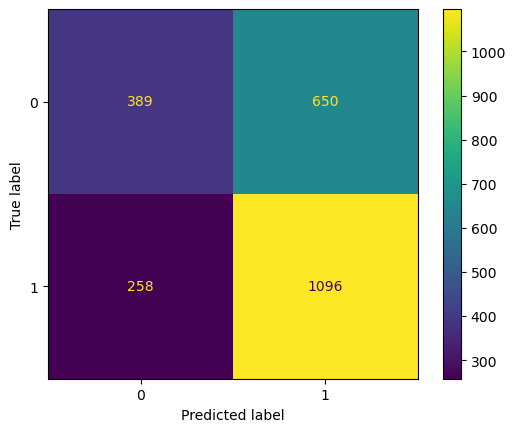

In [38]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_20', results_df, residuals_df_20, stats, svc_param_grid, scaler='yes')
svc_model.full_diag()

results_df

In [39]:
svc_model.params_model

SVC(C=10, kernel='linear', random_state=99)

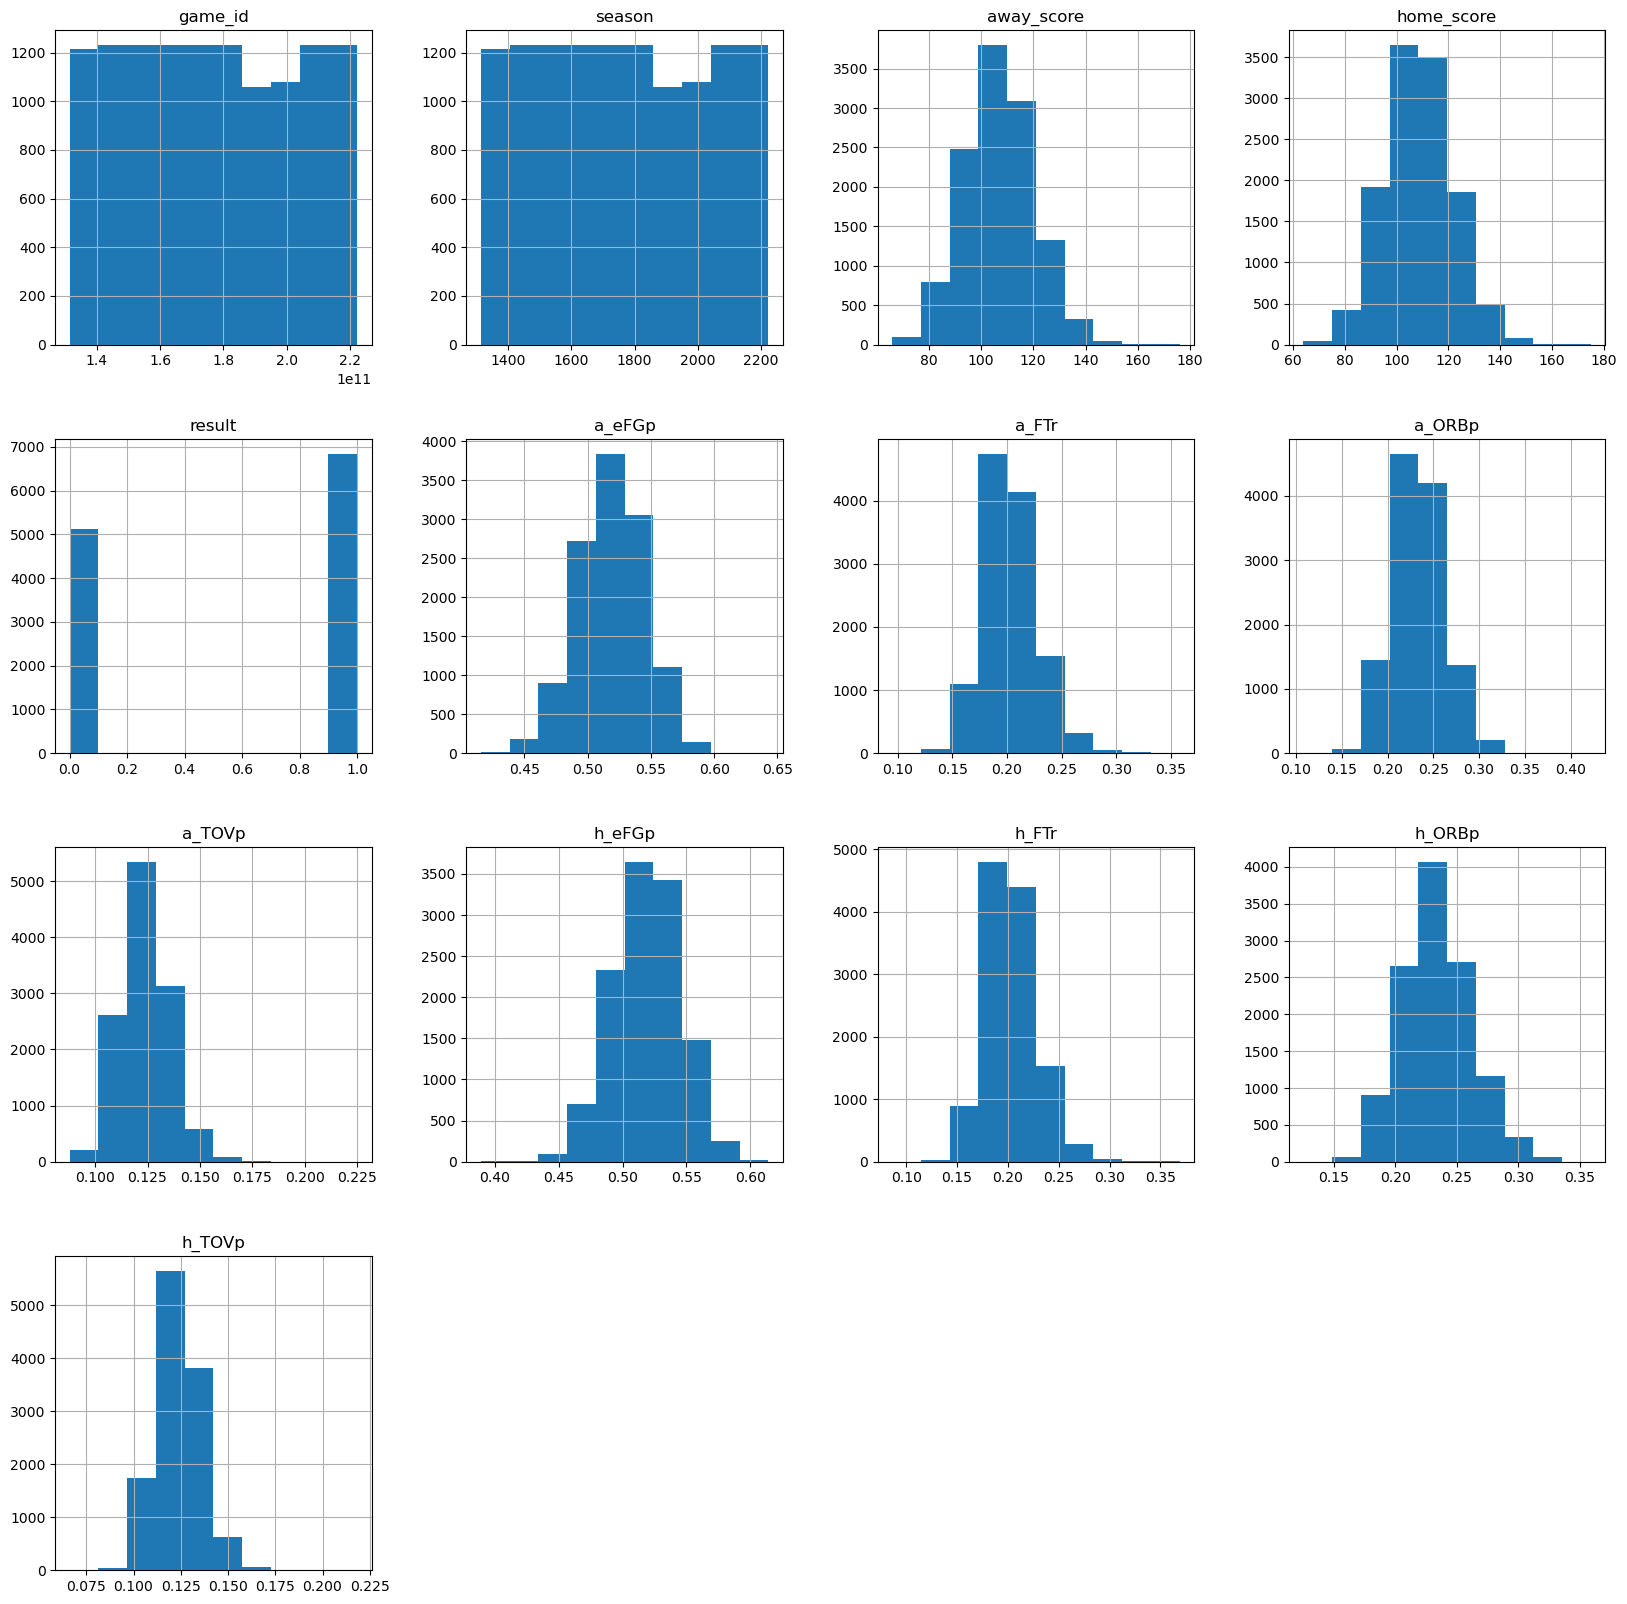

In [40]:
team_factor_30.dropna(inplace=True)
team_factor_30.reset_index(drop=True, inplace=True)
team_factor_30.hist(figsize=(20,20));

In [41]:
team_factor_30['eFGp'] = team_factor_30['a_eFGp'] - team_factor_30['h_eFGp']
team_factor_30['FTr'] = team_factor_30['a_FTr'] - team_factor_30['h_FTr']
team_factor_30['ORBp'] = team_factor_30['a_ORBp'] - team_factor_30['h_ORBp']
team_factor_30['TOVp'] = team_factor_30['a_TOVp'] - team_factor_30['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_30 = pd.DataFrame(columns=['y_true'])
residuals_df_30['y_true'] = game_info['result']

In [42]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_30[stat_columns]
y = team_factor_30['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560

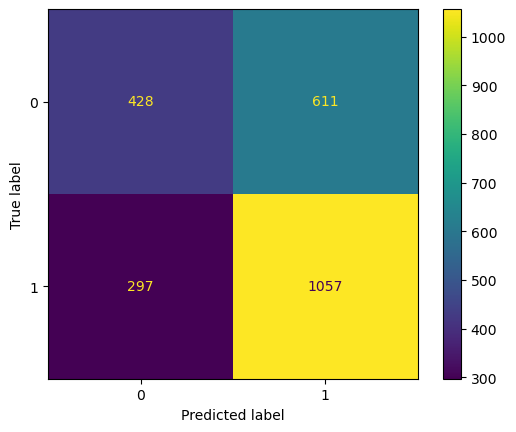

In [43]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_30', results_df, residuals_df_30, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

results_df

In [44]:
log_gs_model.params_model

LogisticRegression(penalty='l1', random_state=99, solver='saga')

#### KNN

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383

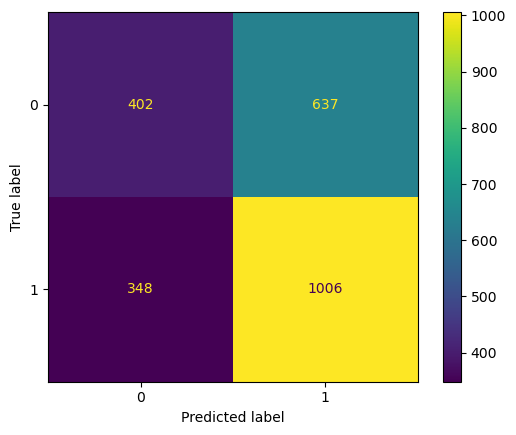

In [45]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_30', results_df, residuals_df_30, stats, knn_param_grid, scaler='yes')
knn_model.full_diag()

results_df

In [46]:
knn_model.params_model

KNeighborsClassifier(n_neighbors=19, p=1)

#### RF

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784

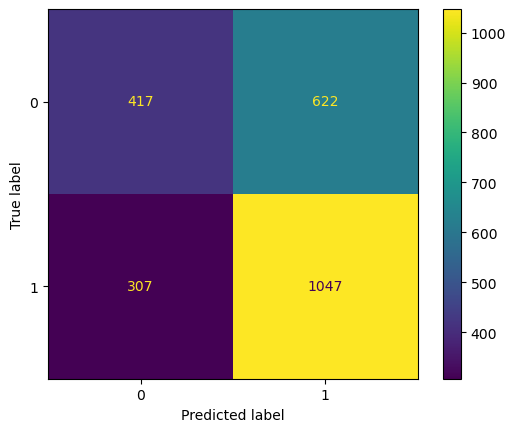

In [47]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [175, 200],
    'max_depth': [5, 7],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_30', results_df, residuals_df_30, stats, rfc_param_grid)
rfc_model.full_diag()

results_df

In [48]:
rfc_model.params_model

RandomForestClassifier(max_depth=7, max_features=None, min_samples_leaf=3,
                       n_estimators=200, random_state=99)

#### GNB

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
15       gnb_4F_30  0.627403      None     0.625209    0.618471

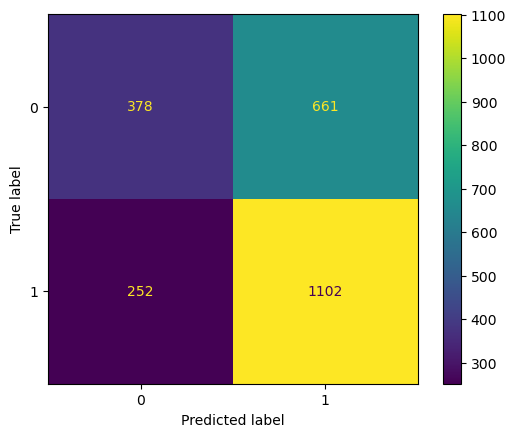

In [49]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_30', results_df, residuals_df_30, stats, None)
gnb_model.full_diag()

results_df

#### SVC

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
15       gnb_4F_30  0.627403      None     0.625209    0.618471
16       svc_4F_30       NaN  0.630643     0.641722    0.621814

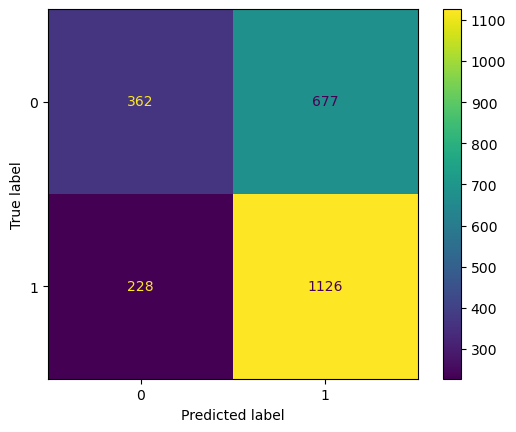

In [50]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_30', results_df, residuals_df_30, stats, svc_param_grid, scaler='yes')
svc_model.full_diag()

results_df

In [51]:
svc_model.params_model

SVC(C=1, gamma='auto', random_state=99)

In [52]:
team_full_20

game_id  season        date away_team  away_score home_team  \
0      131410290001    1314  2013-10-29       ORL          87       IND   
1      131410290002    1314  2013-10-29       CHI          95       MIA   
2      131410290003    1314  2013-10-29       LAC         103       LAL   
3      131410300004    1314  2013-10-30       BRK          94       CLE   
4      131410300005    1314  2013-10-30       BOS          87       TOR   
...             ...     ...         ...       ...         ...       ...   
11974  222304091226    2223  2023-04-09       UTA         117       LAL   
11975  222304091227    2223  2023-04-09       NOP         108       MIN   
11976  222304091228    2223  2023-04-09       MEM         100       OKC   
11977  222304091229    2223  2023-04-09       LAC         119       PHO   
11978  222304091230    2223  2023-04-09       GSW         157       POR   

       home_score  result   a_FG  a_FGA    a_FGp   a_3P  a_3PA    a_3Pp  \
0              97       1    NaN    NaN      NaN    NaN    NaN      NaN   
1             107       1    NaN    NaN      NaN    NaN    NaN      NaN   
2             116       1    NaN    NaN      NaN    NaN    NaN      NaN   
3              98       1    NaN    NaN      NaN    NaN    NaN      NaN   
4              93       1    NaN    NaN      NaN    NaN    NaN      NaN   
...           ...     ...    ...    ...      ...    ...    ...      ...   
11974         128       1  42.60  90.70  0.47090  11.30  34.15  0.32895   
11975         113       1  41.70  85.25  0.48935  12.00  29.55  0.40445   
11976         115       1  45.10  91.15  0.49390  14.45  37.70  0.37950   
11977         114       0  43.25  86.20  0.50325  13.20  33.35  0.38875   
11978         101       0  43.15  89.85  0.48250  15.90  42.55  0.37405   

        a_FT  a_FTA    a_FTp  a_ORB  a_DRB  a_TRB  a_AST  a_STL  a_BLK  a_TOV  \
0        NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1        NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...      ...    ...      ...    ...    ...    ...    ...    ...    ...    ...   
11974  18.95  24.50  0.78135  11.85  37.15  49.00  26.40   5.15   6.00  15.25   
11975  18.35  22.15  0.83635   9.10  33.30  42.40  26.85   7.35   4.15  13.40   
11976  16.20  21.10  0.76275   9.90  33.55  43.45  28.45   7.95   4.95  12.00   
11977  20.15  25.25  0.78660   9.25  32.70  41.95  27.15   8.10   3.90  14.30   
11978  16.80  20.85  0.81095  12.15  33.65  45.80  29.55   7.10   4.50  15.70   

        a_PF   a_PTS    a_TSp   a_eFGp   a_3PAr    a_FTr  a_ORBp  a_DRBp  \
0        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
1        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
2        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
3        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
4        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
...      ...     ...      ...      ...      ...      ...     ...     ...   
11974  19.85  115.45  0.57035  0.53335  0.37760  0.27220  26.085  79.330   
11975  19.70  113.75  0.59895  0.55930  0.34625  0.26255  22.615  78.270   
11976  20.05  120.85  0.60220  0.57320  0.41535  0.23260  22.735  76.355   
11977  19.60  119.85  0.61595  0.58010  0.38725  0.29405  22.060  74.800   
11978  19.90  119.00  0.60325  0.57140  0.47420  0.23520  28.360  74.665   

       a_TRBp  a_ASTp  a_STLp  a_BLKp  a_TOVp   h_FG  h_FGA    h_FGp   h_3P  \
0         NaN     NaN     NaN     NaN     NaN    NaN    NaN      NaN    NaN   
1         NaN     NaN     NaN     NaN     NaN    NaN    NaN      NaN    NaN   
2         NaN     NaN     NaN     NaN     NaN    NaN    NaN      NaN    NaN   
3       

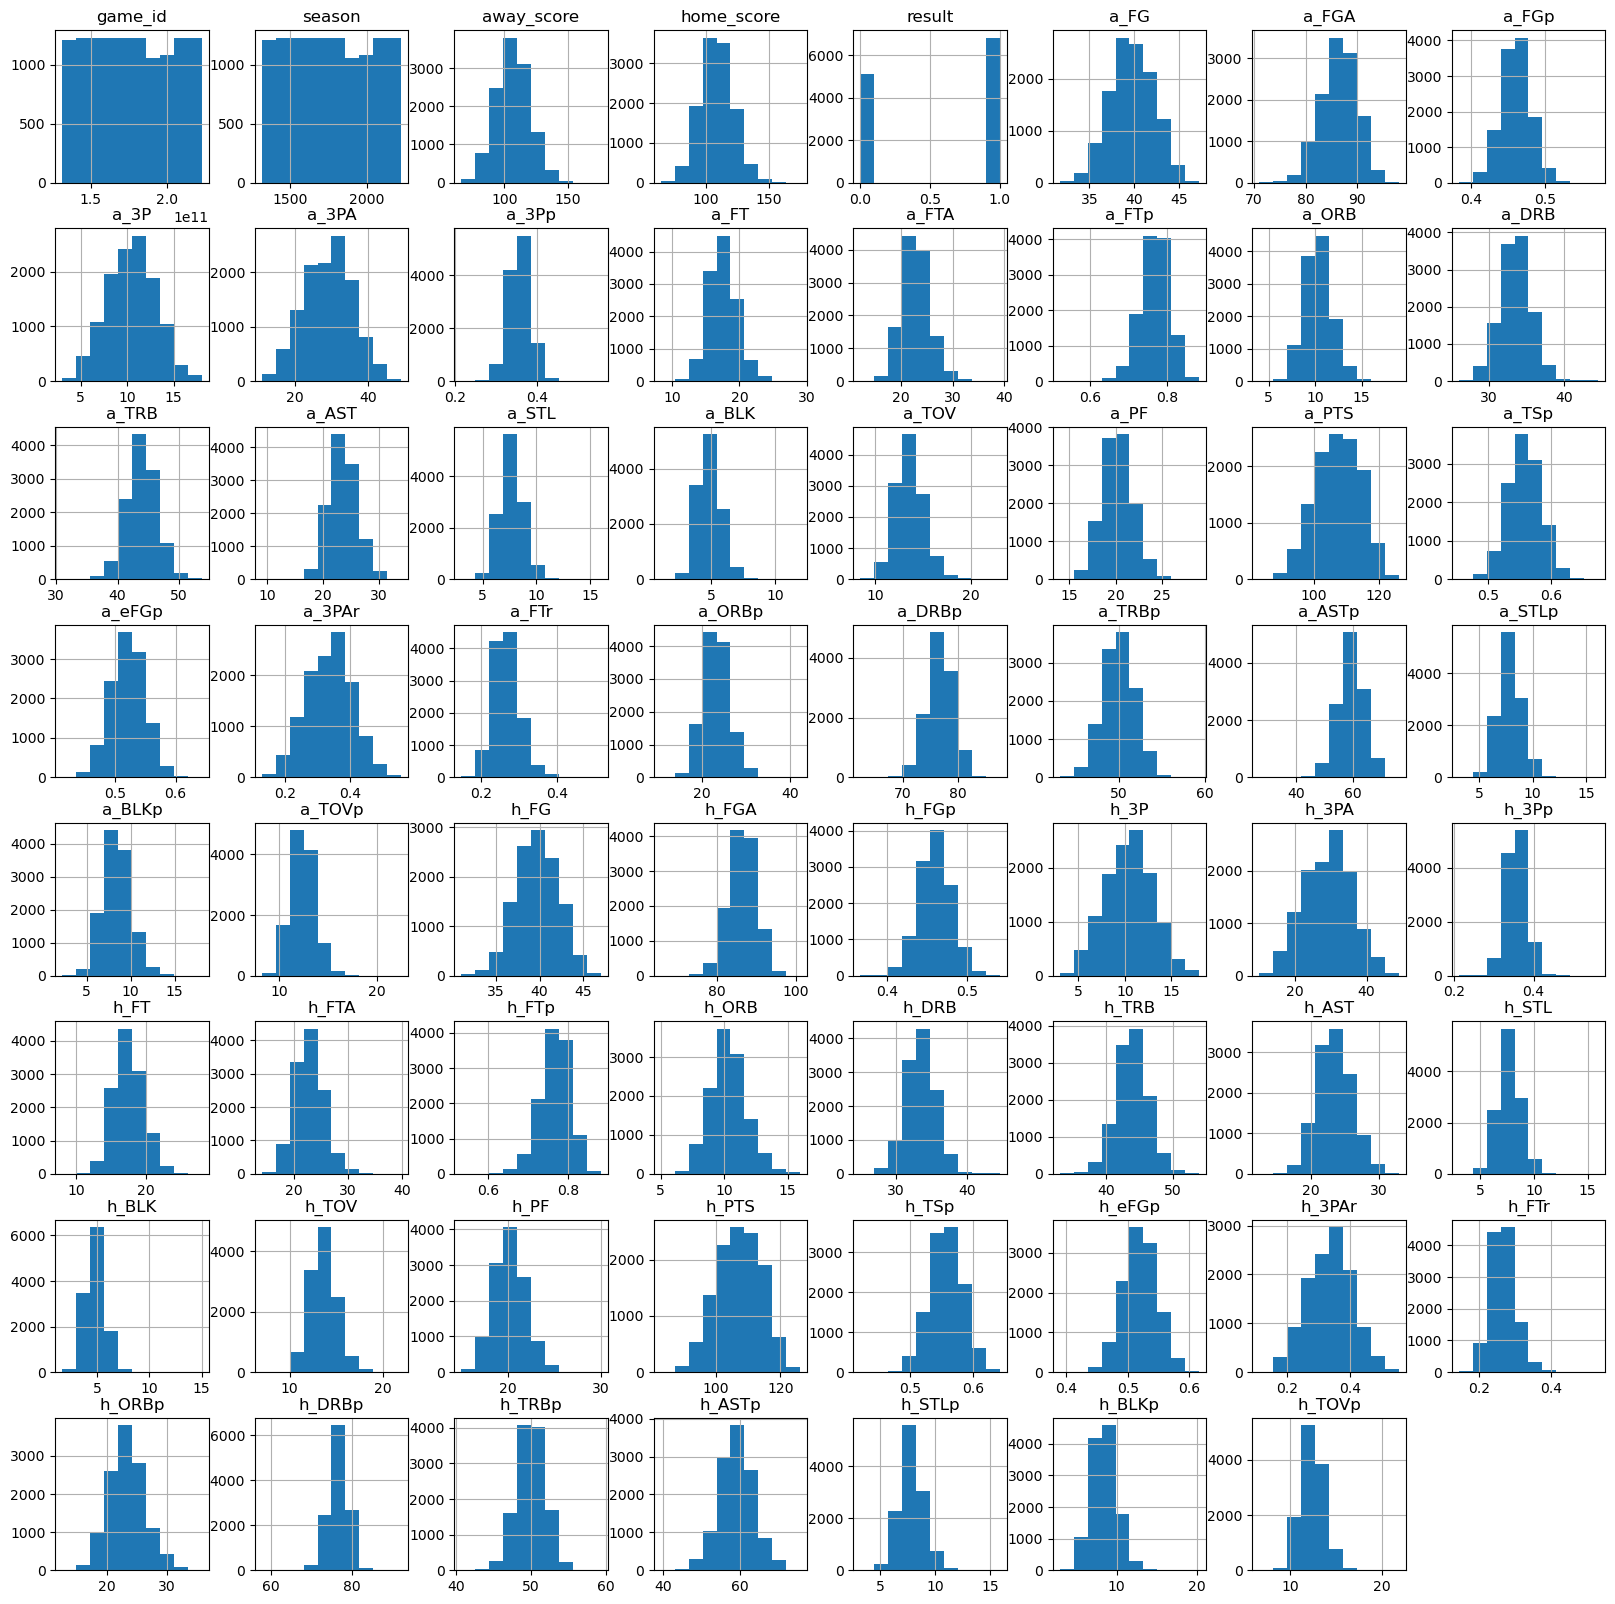

In [53]:
team_full_20.dropna(inplace=True)
team_full_20.reset_index(drop=True, inplace=True)
team_full_20.hist(figsize=(20,20));

In [54]:
stat_columns = team_full_20.loc[:,'a_FG':'h_TOVp'].columns

X = team_full_20[stat_columns]
y = team_full_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

residuals_df_pca = pd.DataFrame(columns=['y_true'])
residuals_df_pca['y_true'] = team_full_20['result']

In [55]:
# Create a pipeline with PCA and Logistic Regression
pipeline = Pipeline([
    ('pca', PCA()),
    ('logreg', LogisticRegression())
])

# Define parameter grid for grid search
param_grid = {
    'pca__n_components': [x for x in range(1,30)],
    'logreg__C': [0.1, 1, 10]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(stats[0], stats[2])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1, 10],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29]})

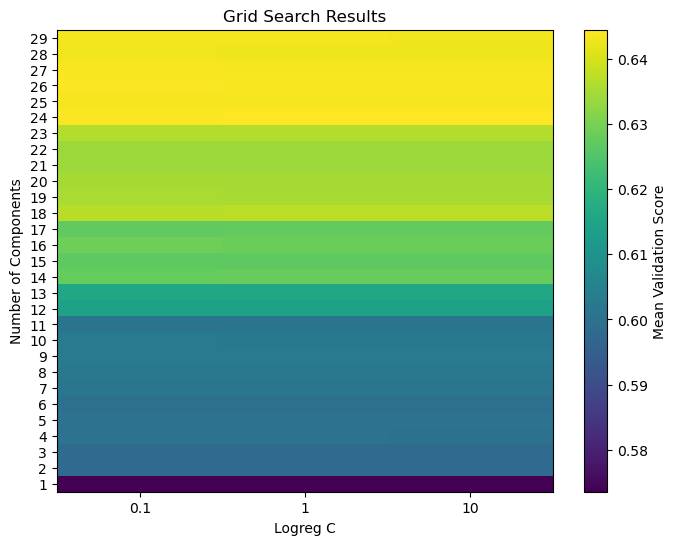

In [56]:
pca_results_df = pd.DataFrame(grid_search.cv_results_).dropna()
pivot = pca_results_df.pivot(index = 'param_pca__n_components', columns='param_logreg__C', values='mean_test_score')

plt.figure(figsize=(8, 6))
plt.title('Grid Search Results')
plt.xlabel('Logreg C')
plt.ylabel('Number of Components')

plt.imshow(pivot, cmap=plt.get_cmap('viridis'), aspect='auto', origin='lower')
plt.xticks(np.arange(len(param_grid['logreg__C'])), param_grid['logreg__C'])
plt.yticks(np.arange(len(param_grid['pca__n_components'])), param_grid['pca__n_components'])
plt.colorbar(label='Mean Validation Score')
plt.show()

In [57]:
# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Predict on the test data using the best estimator
y_pred = best_estimator.predict(stats[1])

# Calculate accuracy
accuracy = accuracy_score(stats[3], y_pred)
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {accuracy:.3f}")

Best Parameters: {'logreg__C': 1, 'pca__n_components': 24}
Test Accuracy: 0.629


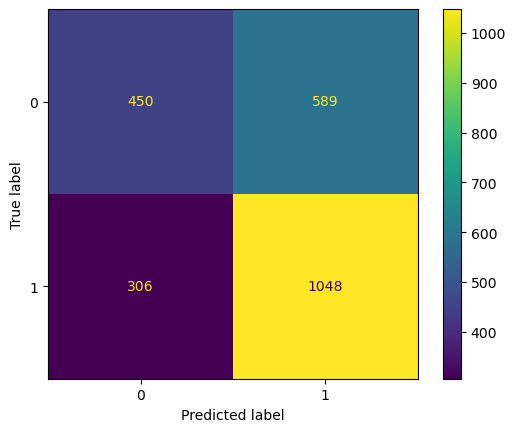

In [58]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0],
}

log_pca = ModelEval(log_gs, 'log_pca', results_df, residuals_df_pca, stats, log_param_grid, pca='yes', n_components=24)
log_pca.full_diag()

In [59]:
log_pca.params_model

LogisticRegression(C=0.01, random_state=99, solver='saga')

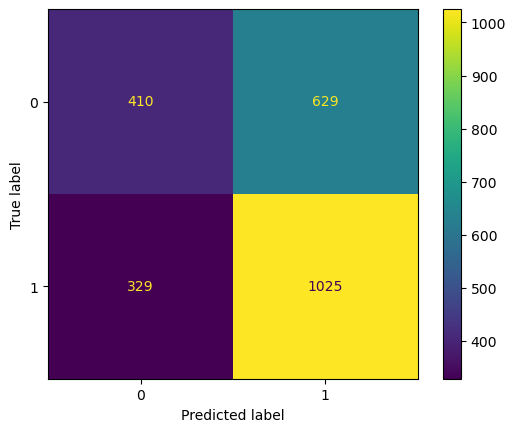

In [60]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [15, 17],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_pca = ModelEval(knn, 'knn_pca', results_df, residuals_df_pca, stats, knn_param_grid, pca='yes', n_components=24)
knn_pca.full_diag()

In [61]:
knn_pca.params_model

KNeighborsClassifier(n_neighbors=17, p=3, weights='distance')

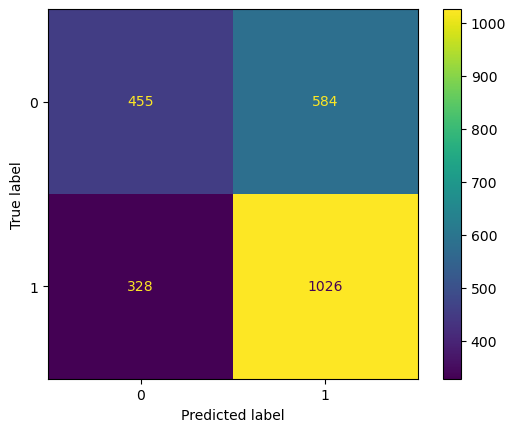

In [62]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [225, 250],
    'max_depth': [5, 6],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'max_features': ['sqrt', None]
}

rfc_pca = ModelEval(rfc, 'rfc_pca', results_df, residuals_df_pca, stats, rfc_param_grid, pca='yes', n_components=24)
rfc_pca.full_diag()

In [63]:
rfc_pca.params_model

RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=5,
                       n_estimators=250, random_state=99)

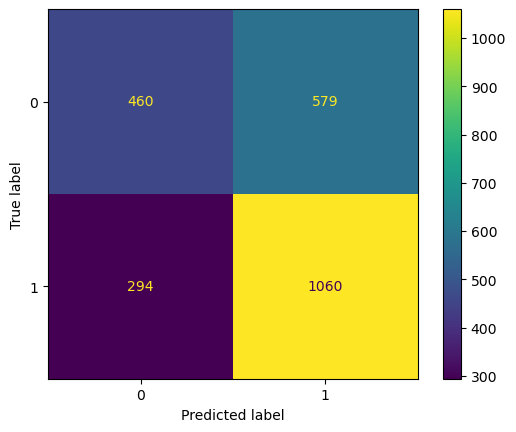

In [64]:
gnb = GaussianNB()
gnb_pca = ModelEval(gnb, 'gnb_pca', results_df, residuals_df_pca, stats, None, pca='yes', n_components=24)
gnb_pca.full_diag()

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
15       gnb_4F_30  0.627403      None     0.625209    0.618471
16       svc_4F_30       NaN  0.630643     0.641722    0.621814
17         log_pca       NaN  0.642349     0.643604    0.625992
18         knn_pca       NaN  0.622177     1.000000    0.599666
19         rfc_pca       NaN    0.6366     0.666074    0.618888
20         gnb_pca  0.638377      None     0.646426    0.635186
21         svc_pca       NaN  0.642454     0.646008    0.627246

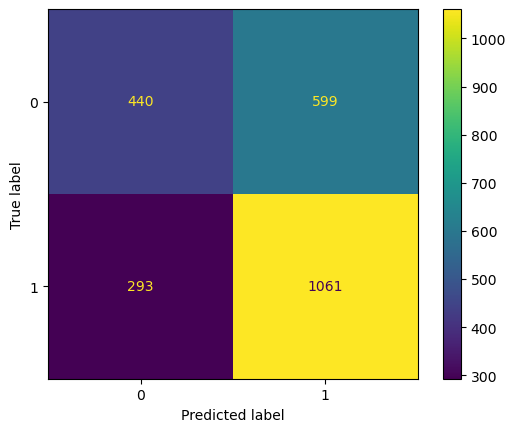

In [65]:
svc = SVC(random_state=seed)
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_pca = ModelEval(svc, 'svc_pca', results_df, residuals_df_pca, stats, svc_param_grid, pca='yes', n_components=24)
svc_pca.full_diag()

results_df

In [66]:
svc_pca.params_model

SVC(C=0.1, kernel='linear', random_state=99)

In [67]:
combo_cols = team_stats.drop(['game_id', 'team', 'MP', 'PM', 'USGp', 'ORtg', 'DRtg', 'BPM'], axis=1).columns

for column in combo_cols:
    team_full_20[column] = team_full_20['a_'+column] - team_full_20['h_'+column]
team_full_20_combined = team_full_20.loc[:, 'FG':'TOVp']
team_full_20_combined

FG    FGA      FGp    3P    3PA      3Pp     FT    FTA      FTp  \
0      1.00 -12.00  0.08500 -4.00 -13.00 -0.03800  -3.00  -6.00  0.09900   
1      5.00   3.00  0.04100  7.00   6.00  0.17500   5.00   0.00  0.21800   
2      2.00  -6.00  0.05000  1.00   5.00 -0.06700  10.00  14.00  0.02600   
3     -7.50 -11.50 -0.02850 -4.50 -12.00  0.03300   8.50   7.00  0.20450   
4      9.00   2.00  0.10200 -2.00  -4.00 -0.01900  -4.00  -8.00  0.08300   
...     ...    ...      ...   ...    ...      ...    ...    ...      ...   
11956  0.85   4.55 -0.01500 -0.15   3.15 -0.04055  -3.15  -3.85  0.00220   
11957 -1.55  -3.65  0.00280 -0.85  -3.10  0.01485   1.55  -1.70  0.13355   
11958  3.40  -0.70  0.03985  2.50   2.50  0.04055  -5.05  -4.50 -0.07160   
11959 -0.25  -4.90  0.02385  1.50   1.05  0.03340   2.85   3.50 -0.01555   
11960  3.60   2.70  0.02775  3.75   6.40  0.03945  -1.10  -2.10  0.02905   

        ORB    DRB    TRB   AST    STL   BLK  TOV     PF    PTS      TSp  \
0     -5.00  -2.00  -7.00 -6.00   1.00  2.00  4.0 -11.00  -5.00  0.06300   
1     -3.00  11.00   8.00  7.00  -3.00  5.00 -1.0   1.00  22.00  0.09700   
2      4.00   7.00  11.00  7.00  -1.00 -3.00  4.0  -1.00  15.00  0.07500   
3      1.50  -5.00  -3.50 -2.00  -1.50 -1.00 -2.5   1.50 -11.00 -0.01200   
4     -5.00   7.00   2.00  1.00  11.00 -2.00  2.0  -9.00  12.00  0.07500   
...     ...    ...    ...   ...    ...   ...  ...    ...    ...      ...   
11956  1.15   2.20   3.35  1.20  -1.25  1.30  1.5   3.30  -1.60 -0.02455   
11957 -0.30  -0.80  -1.10 -1.50  -0.35 -1.50  0.0  -1.00  -2.40  0.01510   
11958 -1.20   1.80   0.60  5.30  -0.40  2.20  0.8   0.00   4.25  0.03705   
11959 -2.30  -0.35  -2.65 -0.40   1.40 -2.45  2.6  -2.25   3.85  0.03760   
11960  3.60   3.10   6.70  5.65  -0.80 -0.90  2.4   0.90   9.85  0.04145   

          eFGp     3PAr      FTr    ORBp    DRBp    TRBp    ASTp  \
0      0.06400 -0.13000 -0.03800  -5.100  -0.900   1.700 -18.500   
1      0.08000  0.06100 -0.01000  -3.800  19.500  11.700   8.000   
2      0.05700  0.06800  0.18300  13.300  13.900  15.800  17.600   
3     -0.04850 -0.10800  0.10300   4.450   9.250   4.100   4.050   
4      0.08800 -0.05800 -0.11000  -3.900  14.500  10.000 -11.800   
...        ...      ...      ...     ...     ...     ...     ...   
11956 -0.01940  0.01725 -0.06210   0.935   2.530   1.625   1.465   
11957  0.00035 -0.02130 -0.00785   1.375   1.735   2.390  -1.195   
11958  0.05435  0.03250 -0.04975  -1.605   2.600   1.210   7.335   
11959  0.03555  0.02985  0.05275  -3.755  -3.080  -2.240  -0.615   
11960  0.04645  0.05775 -0.03265   9.155   0.735   6.755   8.600   

               STLp   BLKp   TOVp  
0      1.500000e+00  2.600  5.700  
1     -3.200000e+00  6.400 -1.200  
2     -1.300000e+00 -6.600  3.400  
3     -7.000000e-01  1.050 -0.900  
4      1.080000e+01 -3.400  1.800  
...             ...    ...    ...  
11956 -1.460000e+00  3.220  0.880  
11957  1.776357e-15 -0.965  0.485  
11958 -4.450000e-01  4.235  0.845  
11959  1.305000e+00 -5.455  2.345  
11960 -8.550000e-01 -1.900  1.720  

[11961 rows x 29 columns]

In [68]:
X = team_full_20_combined
y = team_full_20['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=seed)

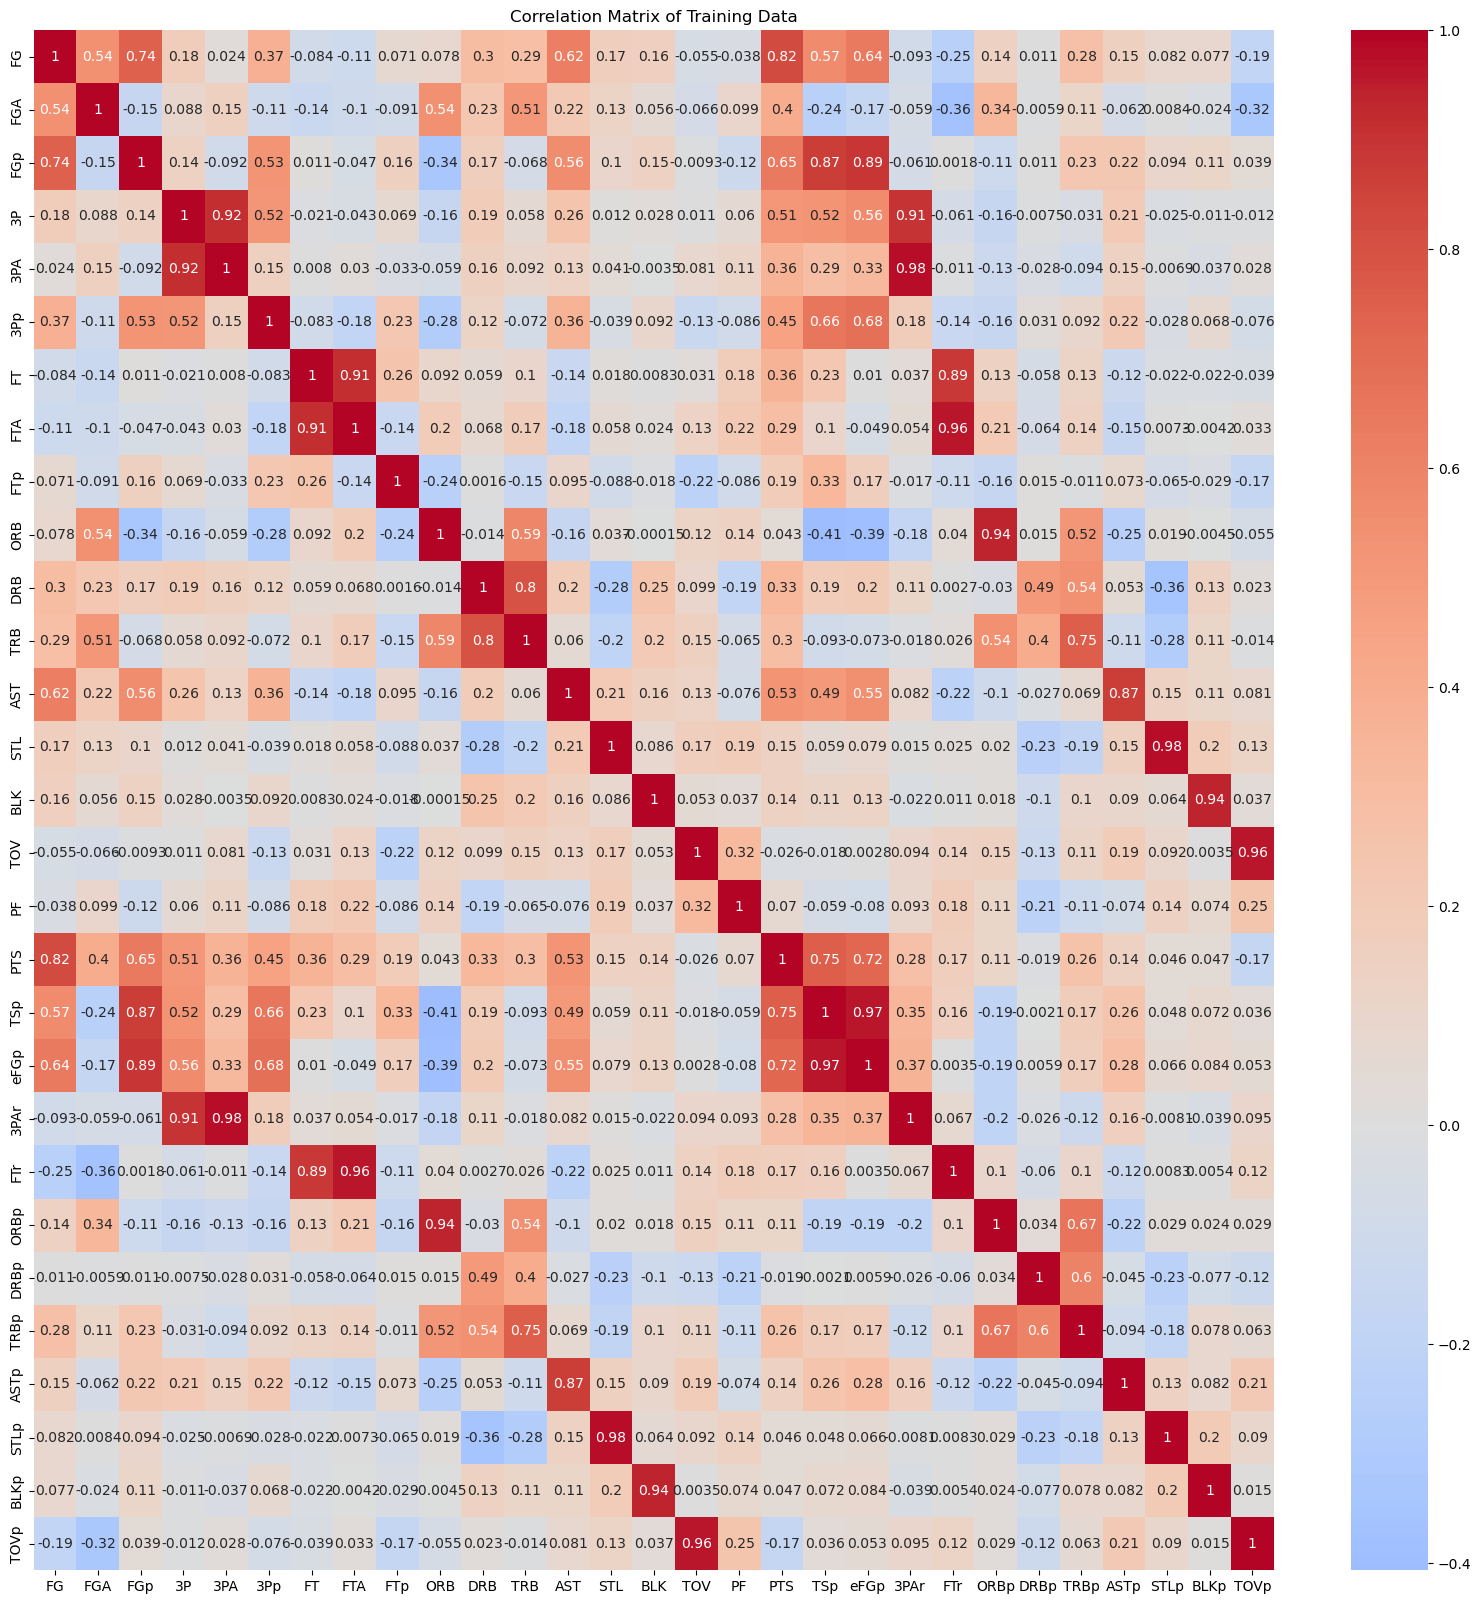

In [69]:
correlation_matrix = X_train.corr()

# create heatmap for correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Training Data')
plt.show()

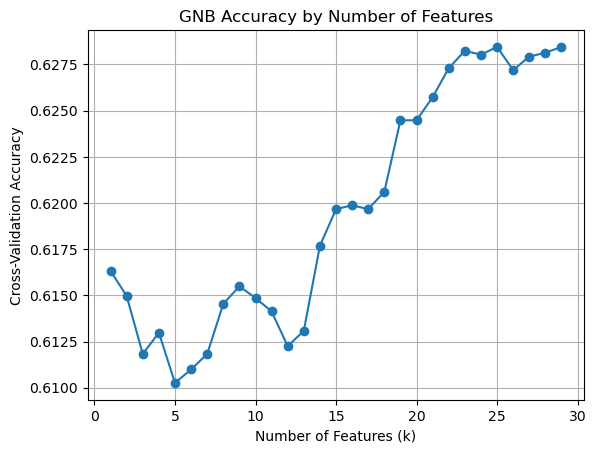

In [70]:
pipe = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('gnb', GaussianNB())
])

# List of values of k to test
k_values = np.arange(1, 30)

# store cross-validation scores for each value of k
cv_scores = []

# perform cross-validation for different values of k
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))

# lot results
plt.plot(k_values, cv_scores, marker='o')
plt.title('GNB Accuracy by Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.savefig('graphs/gnb_acc_by_k', bbox_inches='tight')
plt.show();

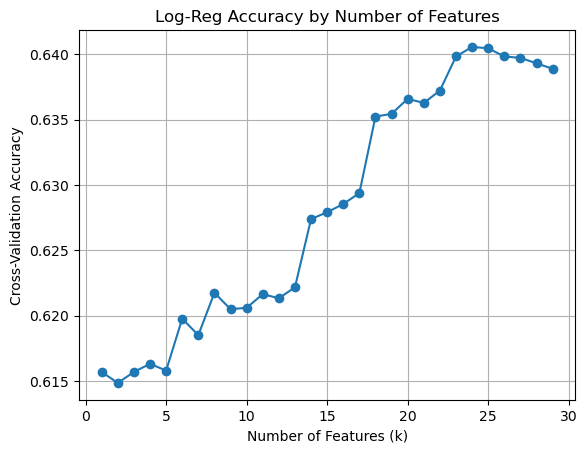

In [71]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('lr', LogisticRegression(C=0.01, random_state=99, solver='saga'))
])

# List of values of k to test
k_values = np.arange(1, 30)

# store cross-validation scores for each value of k
cv_scores = []

# perform cross-validation for different values of k
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))

# lot results
plt.plot(k_values, cv_scores, marker='o')
plt.title('Log-Reg Accuracy by Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.savefig('graphs/log_reg_acc_by_k', bbox_inches='tight')
plt.show();

Again, the model accuracy continues to rise until around `k=24`. But what about the weights for each individual feature?

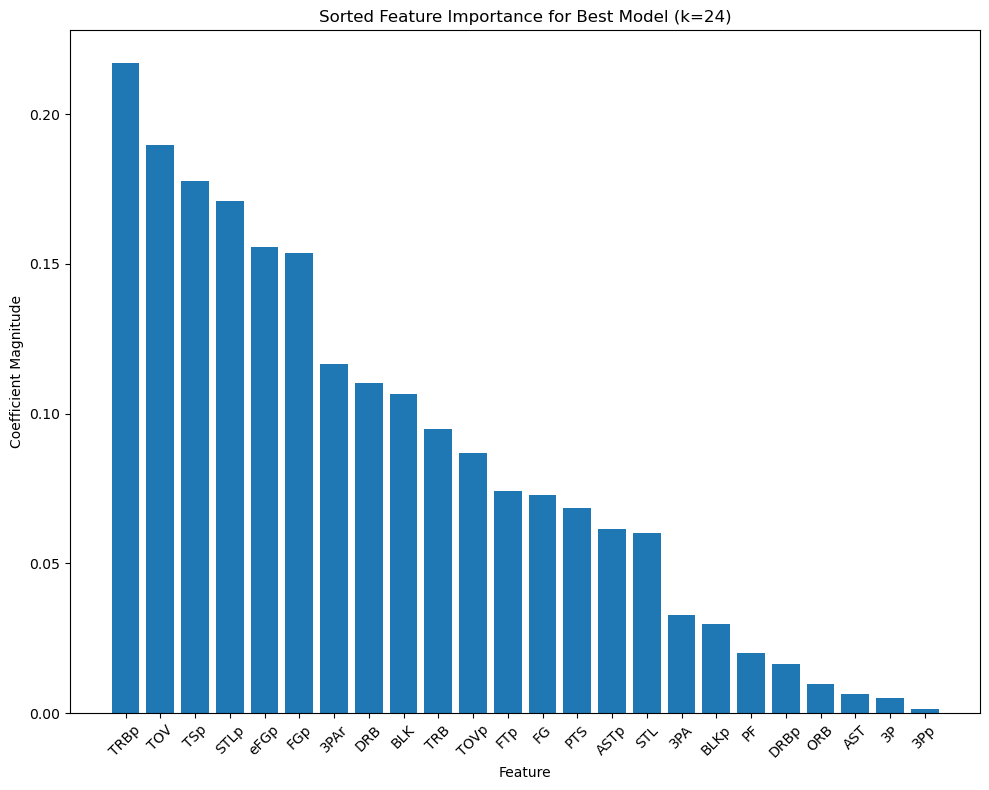

In [72]:
# identify best k value
best_k = k_values[np.argmax(cv_scores)]

# train best model on full training data
pipe.set_params(feature_selection__k=best_k)
best_model = pipe.fit(X_train, y_train)

# indices of selected features
selected_feature_indices = best_model.named_steps['feature_selection'].get_support()

# corresponding feature names
best_selected_feature_names = X.columns[selected_feature_indices]

# sort by feature importances
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = best_selected_feature_names[sorted_indices]

# plot feature importance
plt.figure(figsize=(10,8))
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Sorted Feature Importance for Best Model (k={})'.format(best_k))
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphs/feat_imp_k24', bbox_inches='tight')
plt.show();

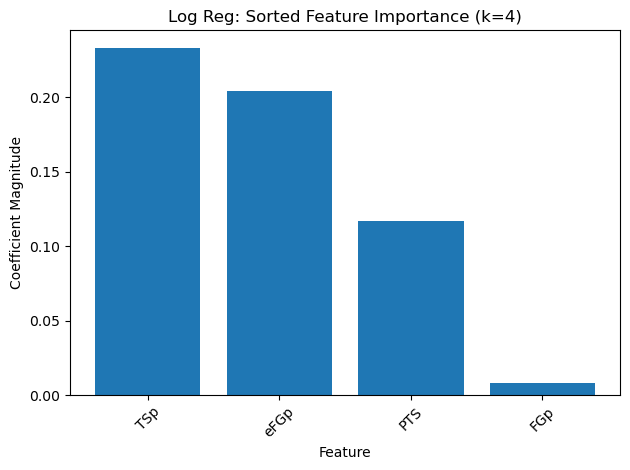

In [73]:
# Train the best model on the full training data
pipe.set_params(feature_selection__k=4)
best_model = pipe.fit(X_train, y_train)

# Get the indices of selected features
selected_feature_indices = best_model.named_steps['feature_selection'].get_support()

# # Get the corresponding feature names
selected_feature_names = X.columns[selected_feature_indices]

# Get the feature importances and sort them in descending order
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]

# Plot sorted feature importance for the best model
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Log Reg: Sorted Feature Importance (k=4)')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphs/feat_imp_k4', bbox_inches='tight')
plt.show();

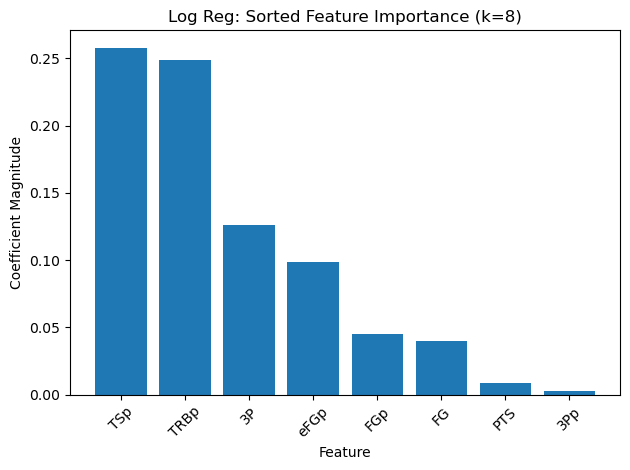

In [74]:
# Train the best model on the full training data
pipe.set_params(feature_selection__k=8)
best_model = pipe.fit(X_train, y_train)

# Get the indices of selected features
selected_feature_indices = best_model.named_steps['feature_selection'].get_support()

# # Get the corresponding feature names
selected_feature_names = X.columns[selected_feature_indices]

# Get the feature importances and sort them in descending order
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]

# Plot sorted feature importance for the best model
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Log Reg: Sorted Feature Importance (k=8)')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphs/feat_imp_k8', bbox_inches='tight')
plt.show();

Now we see that a new statistic, total rebounding percentage (`TRBp`), is the second most important relative feature. This is because all the other statistics are shooting related, so the inclusion of a rebounding statistic captures a lot of new information that the other stats do not. But it is still not more important overall than the 4 statistics from the porevious graph, or it would have been included.

This suggests that it would be beneficial to take the most important stats from each "category," similar to the Four Factors statistic, which accounts for shooting, rebounding, free throws, and turnovers. It is interesting to note, however, that while `eFGp` is traditionally used to represent the shooting category, the data above suggests that `TSp` might be a better choice.

Now I will use the results from the feature selection to train a new round of models

### Feature-Selected Modeling

In [75]:
team_full_20_combined[best_selected_feature_names]

FG      FGp    3P    3PA      3Pp      FTp   ORB    DRB    TRB   AST  \
0      1.00  0.08500 -4.00 -13.00 -0.03800  0.09900 -5.00  -2.00  -7.00 -6.00   
1      5.00  0.04100  7.00   6.00  0.17500  0.21800 -3.00  11.00   8.00  7.00   
2      2.00  0.05000  1.00   5.00 -0.06700  0.02600  4.00   7.00  11.00  7.00   
3     -7.50 -0.02850 -4.50 -12.00  0.03300  0.20450  1.50  -5.00  -3.50 -2.00   
4      9.00  0.10200 -2.00  -4.00 -0.01900  0.08300 -5.00   7.00   2.00  1.00   
...     ...      ...   ...    ...      ...      ...   ...    ...    ...   ...   
11956  0.85 -0.01500 -0.15   3.15 -0.04055  0.00220  1.15   2.20   3.35  1.20   
11957 -1.55  0.00280 -0.85  -3.10  0.01485  0.13355 -0.30  -0.80  -1.10 -1.50   
11958  3.40  0.03985  2.50   2.50  0.04055 -0.07160 -1.20   1.80   0.60  5.30   
11959 -0.25  0.02385  1.50   1.05  0.03340 -0.01555 -2.30  -0.35  -2.65 -0.40   
11960  3.60  0.02775  3.75   6.40  0.03945  0.02905  3.60   3.10   6.70  5.65   

         STL   BLK  TOV     PF    PTS      TSp     eFGp     3PAr    DRBp  \
0       1.00  2.00  4.0 -11.00  -5.00  0.06300  0.06400 -0.13000  -0.900   
1      -3.00  5.00 -1.0   1.00  22.00  0.09700  0.08000  0.06100  19.500   
2      -1.00 -3.00  4.0  -1.00  15.00  0.07500  0.05700  0.06800  13.900   
3      -1.50 -1.00 -2.5   1.50 -11.00 -0.01200 -0.04850 -0.10800   9.250   
4      11.00 -2.00  2.0  -9.00  12.00  0.07500  0.08800 -0.05800  14.500   
...      ...   ...  ...    ...    ...      ...      ...      ...     ...   
11956  -1.25  1.30  1.5   3.30  -1.60 -0.02455 -0.01940  0.01725   2.530   
11957  -0.35 -1.50  0.0  -1.00  -2.40  0.01510  0.00035 -0.02130   1.735   
11958  -0.40  2.20  0.8   0.00   4.25  0.03705  0.05435  0.03250   2.600   
11959   1.40 -2.45  2.6  -2.25   3.85  0.03760  0.03555  0.02985  -3.080   
11960  -0.80 -0.90  2.4   0.90   9.85  0.04145  0.04645  0.05775   0.735   

         TRBp    ASTp          STLp   BLKp   TOVp  
0       1.700 -18.500  1.500000e+00  2.600  5.700  
1      11.700   8.000 -3.200000e+00  6.400 -1.200  
2      15.800  17.600 -1.300000e+00 -6.600  3.400  
3       4.100   4.050 -7.000000e-01  1.050 -0.900  
4      10.000 -11.800  1.080000e+01 -3.400  1.800  
...       ...     ...           ...    ...    ...  
11956   1.625   1.465 -1.460000e+00  3.220  0.880  
11957   2.390  -1.195  1.776357e-15 -0.965  0.485  
11958   1.210   7.335 -4.450000e-01  4.235  0.845  
11959  -2.240  -0.615  1.305000e+00 -5.455  2.345  
11960   6.755   8.600 -8.550000e-01 -1.900  1.720  

[11961 rows x 24 columns]

In [76]:
X = team_full_20_combined[best_selected_feature_names]
y = team_factor_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

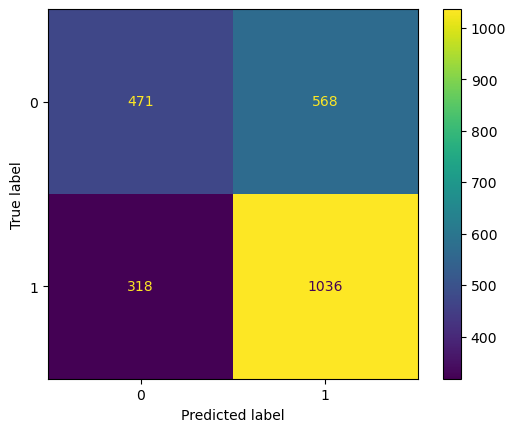

In [77]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_fs_model = ModelEval(log_gs, 'log_fs', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_fs_model.full_diag()

In [78]:
log_fs_model.params_model

LogisticRegression(C=0.01, penalty=None, random_state=99, solver='saga')

#### KNN

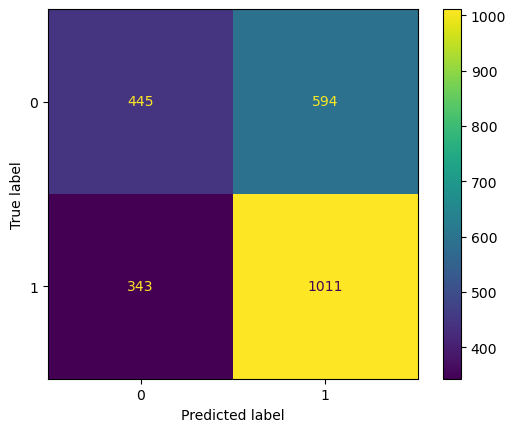

In [79]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_fs_model = ModelEval(knn, 'knn_fs', results_df, residuals_df, stats, knn_param_grid, scaler='yes')
knn_fs_model.full_diag()

In [80]:
knn_fs_model.params_model

KNeighborsClassifier(n_neighbors=21)

#### RF

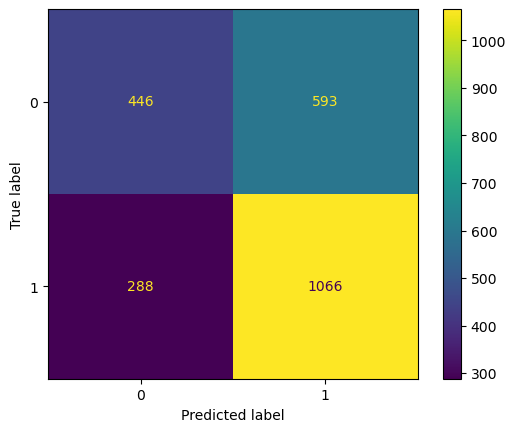

In [81]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [150, 200, 250],
    'max_depth': [6],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt', None]
}

rfc_fs_model = ModelEval(rfc, 'rfc_fs', results_df, residuals_df, stats, rfc_param_grid)
rfc_fs_model.full_diag()

In [82]:
rfc_fs_model.params_model

RandomForestClassifier(max_depth=6, min_samples_leaf=4, n_estimators=200,
                       random_state=99)

#### GNB

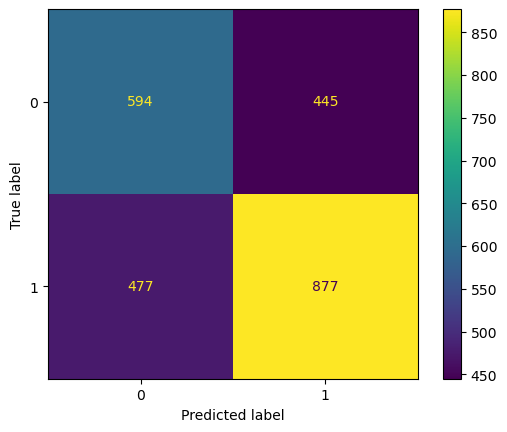

In [83]:
gnb = GaussianNB()
gnb_fs_model = ModelEval(gnb, 'gnb_fs', results_df, residuals_df, stats, None)
gnb_fs_model.full_diag()

#### SVC

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
15       gnb_4F_30  0.627403      None     0.625209    0.618471
16       svc_4F_30       NaN  0.630643     0.641722    0.621814
17         log_pca       NaN  0.642349     0.643604    0.625992
18         knn_pca       NaN  0.622177     1.000000    0.599666
19         rfc_pca       NaN    0.6366     0.666074    0.618888
20         gnb_pca  0.638377      None     0.646426    0.635186
21         svc_pca       NaN  0.642454     0.646008    0.627246
22          log_fs       NaN  0.640154     0.643290    0.629753
23          knn_fs       NaN  0.625313     0.667015    0.608441
24          rfc_fs       NaN  0.635136     0.677258    0.631843
25          gnb_fs  0.628448      None     0.630017    0.614710
26          svc_fs       NaN  0.639945     0.642768    0.625157

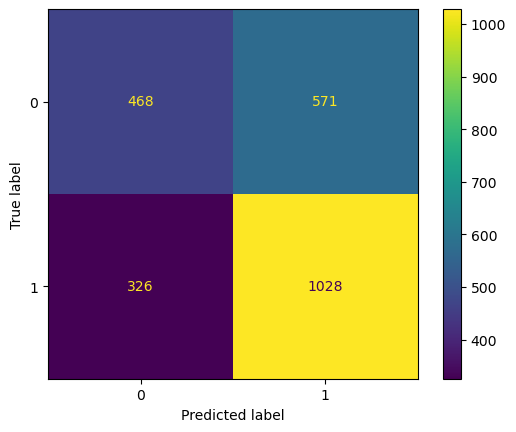

In [84]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_fs_model = ModelEval(svc, 'svc_fs', results_df, residuals_df, stats, svc_param_grid, scaler='yes')
svc_fs_model.full_diag()

results_df

In [85]:
svc_fs_model.params_model

SVC(C=10, kernel='linear', random_state=99)

The feature-selected models slightly outperform the other model groups as a whole, though the top performing model (RF) was just shy of of the GNB PCA model. Looking at the Random Forst model also provides some insight into feature selection:

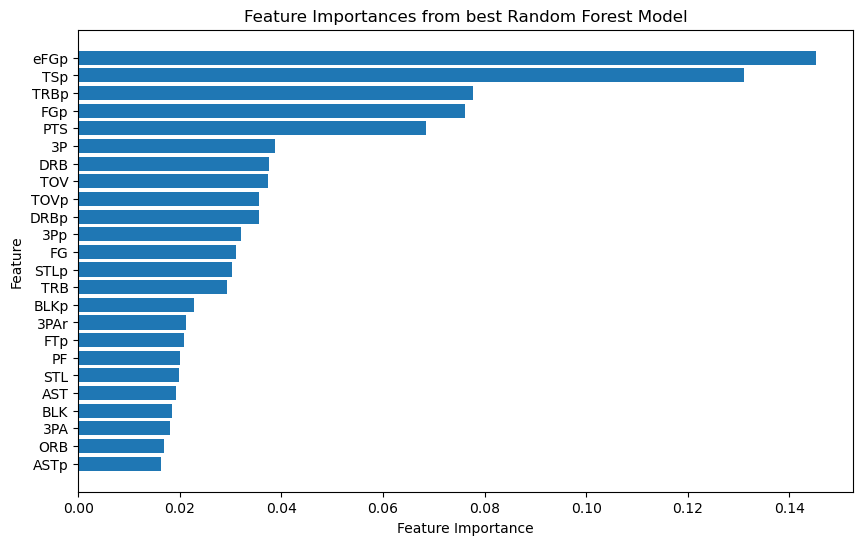

In [86]:
feat_importances = rfc_fs_model.params_model.feature_importances_
feat_names = rfc_fs_model.params_model.feature_names_in_

sorted_indices = np.argsort(feat_importances)[::]
sorted_feat_importances = feat_importances[sorted_indices]
sorted_feat_names = [feat_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(list(range(len(sorted_feat_importances))), sorted_feat_importances, align='center')
plt.yticks(range(len(sorted_feat_importances)), sorted_feat_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from best Random Forest Model')
plt.savefig('graphs/feat_imp_RF_best', bbox_inches='tight')
plt.show();

In [87]:
def calc_K(MOV, elo_diff_winner):
    
    K = 20 * ( (MOV + 3)**0.8 / (7.5 + 0.006*(elo_diff_winner)) )
    return K

def new_season_elo_adj(elo):
    new_season_elo = (0.75*elo) + (0.25*1505)
    return new_season_elo

def update_elo(away_team, away_elo, away_score,
               home_team, home_elo, home_score):
    
    away_elo_og = away_elo
    home_elo_og = home_elo
    
    # set home court advantage
    home_adv = 100
    home_elo += home_adv
    
    # determine winner/loser
    if away_score > home_score:
        
        winner_score = away_score
        winner_elo = away_elo
        
        loser_score = home_score
        loser_elo = home_elo
        
        S_away = 1
        S_home = 0
    else:
        winner = home_team
        winner_score = home_score
        winner_elo = home_elo
        
        loser_score = away_score
        loser_elo = away_elo
        S_away = 0
        S_home = 1
        
    elo_diff_winner = winner_elo - loser_elo
    
    # expected win probability
    E_away = 1 / (1 + 10**((home_elo-away_elo)/400))
    E_home = 1 / (1 + 10**((away_elo-home_elo)/400))
    
    MOV = winner_score - loser_score
    
    K = calc_K(MOV=MOV, elo_diff_winner=elo_diff_winner)
    
    # calculate new elo
    away_elo_new = K*(S_away-E_away) + away_elo_og
    home_elo_new = K*(S_home-E_home) + home_elo_og
    
    return away_elo_new, home_elo_new

I used a dataset containing all historical Elo ratings from the FTE system, which can be found on github [here](https://github.com/rogerfitz/tutorials/tree/master/Nate%20Silver%20ELO), to set each team's initial Elo and verify my Elo calculations through the first season of my data (2013-2014).

In [88]:
# historical NBA elo ratings
nba_all_elo = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/nbaallelo.csv')
test_elo_season = nba_all_elo[(nba_all_elo['year_id'] == 2014) & (nba_all_elo['is_playoffs'] == 0)]
test_elo_season.head()

gameorder       game_id lg_id  _iscopy  year_id   date_game  \
121054      60528  201310290IND   NBA        1     2014  10/29/2013   
121055      60528  201310290IND   NBA        0     2014  10/29/2013   
121056      60529  201310290LAL   NBA        0     2014  10/29/2013   
121057      60529  201310290LAL   NBA        1     2014  10/29/2013   
121058      60530  201310290MIA   NBA        1     2014  10/29/2013   

        seasongame  is_playoffs team_id   fran_id  pts      elo_i      elo_n  \
121054           1            0     ORL     Magic   87  1313.2317  1311.5338   
121055           1            0     IND    Pacers   97  1583.5721  1585.2700   
121056           1            0     LAL    Lakers  116  1511.0200  1522.1942   
121057           1            0     LAC  Clippers  103  1586.5884  1575.4142   
121058           1            0     CHI     Bulls   95  1519.9124  1516.6088   

        win_equiv opp_id  opp_fran  opp_pts  opp_elo_i  opp_elo_n  \
121054  22.266760    IND    Pacers       97  1583.5721  1585.2700   
121055  49.365368    ORL     Magic       87  1313.2317  1311.5338   
121056  42.866776    LAC  Clippers      103  1586.5884  1575.4142   
121057  48.369659    LAL    Lakers      116  1511.0200  1522.1942   
121058  42.281761    MIA      Heat      107  1691.8896  1695.1932   

       game_location game_result  forecast notes  
121054             A           L  0.106039   NaN  
121055             H           W  0.893961   NaN  
121056             H           W  0.535102   NaN  
121057             A           L  0.464898   NaN  
121058             A           L  0.172841   NaN

In [89]:
# store each team's initial elo
first_game_df = test_elo_season[test_elo_season['seasongame'] == 1]
first_game_df['team_id'].replace('CHA', 'CHO', inplace=True)
initial_elo_df = first_game_df[['team_id', 'elo_i']]
initial_elo_df.head()

team_id      elo_i
121054     ORL  1313.2317
121055     IND  1583.5721
121056     LAL  1511.0200
121057     LAC  1586.5884
121058     CHI  1519.9124

In [90]:
# instantiate dict with lists of elo changes per team per season
elo_dict = {}
for team_id in initial_elo_df['team_id']:
    # empty lists for each team each season
    elo_dict[team_id] = {season: [] for season in game_info['season'].unique()}
    # add starting elo into the first season for each team
    elo_dict[team_id][1314].append(initial_elo_df['elo_i'][initial_elo_df['team_id'] == team_id].iloc[0])

In [91]:
seasons = list(game_info['season'].unique())
# create new columns in game_info to store the elo changes
game_info[['away_elo_i', 'away_elo_n', 'home_elo_i', 'home_elo_n']] = None

for idx in game_info.index:
    # store current season to determine when to perform season rating adjustment
    curr_season = game_info.loc[idx]['season']
    # when current season list is empty, trigger season rating adjustment for away team
    if elo_dict[game_info.loc[idx,'away_team']][curr_season] == []:
        
        prev_season_idx = seasons.index(curr_season)-1
        prev_elo = elo_dict[game_info.loc[idx,'away_team']][seasons[prev_season_idx]][-1]
        new_season_elo = new_season_elo_adj(prev_elo)
        elo_dict[game_info.loc[idx,'away_team']][curr_season].append(new_season_elo)
    # when current season list is empty, trigger season rating adjustment for home team
    if elo_dict[game_info.loc[idx,'home_team']][curr_season] == []:
        
        prev_season_idx = seasons.index(curr_season)-1
        prev_elo = elo_dict[game_info.loc[idx,'home_team']][seasons[prev_season_idx]][-1]
        new_season_elo = new_season_elo_adj(prev_elo)
        elo_dict[game_info.loc[idx,'home_team']][curr_season].append(new_season_elo)
        
    # determine current elo before each game
    away_elo_current = elo_dict[game_info.loc[idx,'away_team']][curr_season][-1]
    home_elo_current = elo_dict[game_info.loc[idx,'home_team']][curr_season][-1]
    
    # update elo after each game
    away_elo_new, home_elo_new = update_elo(away_team = game_info.loc[idx,'away_team'],
                                            away_elo = away_elo_current,
                                            away_score = game_info.loc[idx,'away_score'],
                                            home_team = game_info.loc[idx,'home_team'],
                                            home_elo = home_elo_current,
                                            home_score = game_info.loc[idx,'home_score'])
    # store elos in game_info
    game_info['away_elo_i'][idx] = away_elo_current
    game_info['away_elo_n'][idx] = away_elo_new
    game_info['home_elo_i'][idx] = home_elo_current
    game_info['home_elo_n'][idx] = home_elo_new
    
    # store elos in elo_dict
    elo_dict[game_info.loc[idx,'away_team']][curr_season].append(away_elo_new)
    elo_dict[game_info.loc[idx,'home_team']][curr_season].append(home_elo_new)

Now that we have Elo updates for each NBA game, I can use them to predict the winner. All I need to do is predict a win for the team with the higher current Elo, after accounting for the home court advantage.

In [92]:
game_info['elo_pred'] = None
for idx in game_info.index:
    
    # predictions based on each team's current elo
    if game_info['away_elo_i'][idx] > game_info['home_elo_i'][idx]+100:
        game_info['elo_pred'][idx] = 0
    elif game_info['away_elo_i'][idx] < game_info['home_elo_i'][idx]+100:
        game_info['elo_pred'][idx] = 1
        
game_info.head()

game_id  season        date away_team  away_score home_team  \
0  131410290001    1314  2013-10-29       ORL          87       IND   
1  131410290002    1314  2013-10-29       CHI          95       MIA   
2  131410290003    1314  2013-10-29       LAC         103       LAL   
3  131410300004    1314  2013-10-30       BRK          94       CLE   
4  131410300005    1314  2013-10-30       BOS          87       TOR   

   home_score  result away_elo_i   away_elo_n home_elo_i   home_elo_n elo_pred  
0          97       1  1313.2317  1311.533869  1583.5721  1585.269931        1  
1         107       1  1519.9124  1516.608783  1691.8896  1695.193217        1  
2         116       1  1586.5884  1575.414216    1511.02  1522.194184        1  
3          98       1  1548.4365  1540.172399  1369.2823  1377.546401        0  
4          93       1  1484.9615  1479.784941  1483.9835  1489.160059        1

In [93]:
# calculate elo accuracy
residuals = game_info['result'] - game_info['elo_pred']
accuracy = len(residuals[residuals==0]) / len(residuals)
accuracy

0.6528925619834711

In [94]:
# store elo results in the results_df
elo_results = {'model_name': 'elo', 'cv_score': None, 'gs_score': None, 'train_score': None, 'test_score': accuracy}
results_df = results_df.append(elo_results, ignore_index=True)
results_df

model_name  cv_score  gs_score  train_score  test_score
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
1        log_4F_10  0.610995       NaN     0.615907    0.607188
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
5        gnb_4F_10  0.613921      None     0.617057    0.610949
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
10       gnb_4F_20  0.622491      None     0.623537    0.613874
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
13       knn_4F_30       NaN   0.61089     0.654473    0.588383
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
15       gnb_4F_30  0.627403      None     0.625209    0.618471
16       svc_4F_30       NaN  0.630643     0.641722    0.621814
17         log_pca       NaN  0.642349     0.643604    0.625992
18         knn_pca       NaN  0.622177     1.000000    0.599666
19         rfc_pca       NaN    0.6366     0.666074    0.618888
20         gnb_pca  0.638377      None     0.646426    0.635186
21         svc_pca       NaN  0.642454     0.646008    0.627246
22          log_fs       NaN  0.640154     0.643290    0.629753
23          knn_fs       NaN  0.625313     0.667015    0.608441
24          rfc_fs       NaN  0.635136     0.677258    0.631843
25          gnb_fs  0.628448      None     0.630017    0.614710
26          svc_fs       NaN  0.639945     0.642768    0.625157
27             elo       NaN      None          NaN    0.652893

In [95]:
results_df.sort_values('test_score', ascending=False)

model_name  cv_score  gs_score  train_score  test_score
27             elo       NaN      None          NaN    0.652893
20         gnb_pca  0.638377      None     0.646426    0.635186
24          rfc_fs       NaN  0.635136     0.677258    0.631843
22          log_fs       NaN  0.640154     0.643290    0.629753
21         svc_pca       NaN  0.642454     0.646008    0.627246
17         log_pca       NaN  0.642349     0.643604    0.625992
26          svc_fs       NaN  0.639945     0.642768    0.625157
16       svc_4F_30       NaN  0.630643     0.641722    0.621814
7     log_gs_4F_20       NaN  0.629911     0.629494    0.620560
11       svc_4F_20       NaN  0.630852     0.631166    0.620560
12    log_gs_4F_30       NaN  0.630225     0.631375    0.620560
2     log_gs_4F_10       NaN  0.617893     0.618834    0.619306
19         rfc_pca       NaN    0.6366     0.666074    0.618888
15       gnb_4F_30  0.627403      None     0.625209    0.618471
9        rfc_4F_20       NaN  0.630538     0.657086    0.617217
25          gnb_fs  0.628448      None     0.630017    0.614710
10       gnb_4F_20  0.622491      None     0.623537    0.613874
14       rfc_4F_30       NaN  0.634719     0.679975    0.611784
5        gnb_4F_10  0.613921      None     0.617057    0.610949
4        rfc_4F_10       NaN  0.620297     0.636601    0.610531
23          knn_fs       NaN  0.625313     0.667015    0.608441
6        svc_4F_10       NaN  0.618207     0.626359    0.608023
1        log_4F_10  0.610995       NaN     0.615907    0.607188
3        knn_4F_10       NaN  0.590613     0.646112    0.600084
18         knn_pca       NaN  0.622177     1.000000    0.599666
0   log_4F_8var_10  0.600230       NaN     0.607441    0.598412
8        knn_4F_20       NaN  0.605141     0.650293    0.591308
13       knn_4F_30       NaN   0.61089     0.654473    0.588383

In [96]:
top_10 = results_df.sort_values('test_score', ascending=False)[0:10].reset_index(drop=True)
top_10['test_score'] = round(top_10['test_score']*100, 1)
top_10.rename(columns={'test_score': 'test_accuracy'}, inplace=True)
top_10[['model_name', 'test_accuracy']]

model_name  test_accuracy
0           elo           65.3
1       gnb_pca           63.5
2        rfc_fs           63.2
3        log_fs           63.0
4       svc_pca           62.7
5       log_pca           62.6
6        svc_fs           62.5
7     svc_4F_30           62.2
8  log_gs_4F_20           62.1
9     svc_4F_20           62.1

There were incremental improvements moving from 10-game averages to 20-game averages, but as mentioned earlier, the machine learning models all behaved similarly, with a tendency to favor the home team (false-positives), and each had similar seasonal error distribution. Because of this, an ensemble model is unlikely to see large improvements in accuracy. Ultimately, my recommendation is for Stat-Ball to use the Elo rating system. It was the most accurate model, while also requiring the least amount of data and computation. In fact, it is 3% higher than the next closest model. For perspective, here is a plot of the top 5 models:

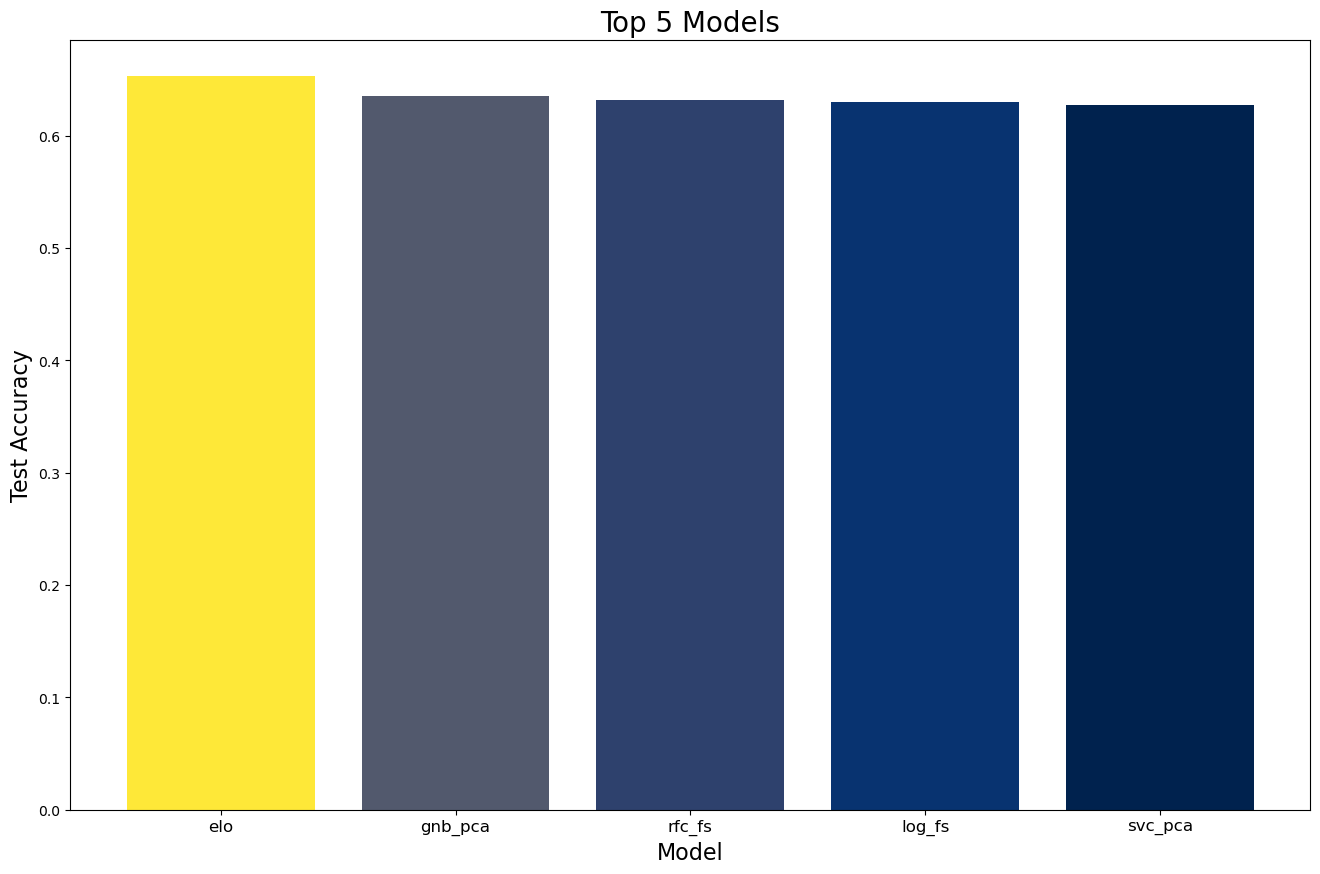

In [97]:
top_models = results_df[['model_name', 'test_score']].sort_values('test_score', ascending=False)[0:5]

cmap = plt.get_cmap("cividis")
heights = list(top_models['test_score'])
# rescale = lambda z: (z - np.min(z)) / (np.max(z) - np.min(z))
rescale = lambda z: (z - np.min(z)) / (np.max(z) - np.min(z))

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Top 5 Models', fontsize=20)
ax.set_xlabel('Model', fontsize=16)
ax.set_ylabel('Test Accuracy', fontsize=16)
ax.set_xticks(range(len(top_models)))
ax.set_xticklabels(top_models['model_name'], fontsize=12)

# plot error per game by season
plt.bar(x=range(len(top_models)), height=top_models['test_score'], color=cmap(rescale(top_models['test_score'])))
plt.savefig('graphs/top_5_models', bbox_inches='tight')
plt.show();